In [1]:
pip install handyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=89e3060f9c907b4ef657fcc901551834beb9485b420163c8eda65c1917ab6321
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType, TimestampType

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()


In [5]:
# Define the schema for the dataset
schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("vendor_id", StringType(), True),
    StructField("rate_code", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_time_in_secs", IntegerType(), True),
    StructField("trip_distance", FloatType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True)
])

In [6]:
df1 = pd.read_csv('/content/gdrive/MyDrive/Data Analysis/trip_data_12.csv')

In [7]:
df1.columns

Index(['medallion', ' hack_license', ' vendor_id', ' rate_code',
       ' store_and_fwd_flag', ' pickup_datetime', ' dropoff_datetime',
       ' passenger_count', ' trip_time_in_secs', ' trip_distance',
       ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude',
       ' dropoff_latitude'],
      dtype='object')

In [8]:
import pandas as pd

# First, clean up the column names to remove leading spaces
df1.columns = df1.columns.str.strip()

# Now 'pickup_datetime' should be available without leading spaces
# Convert 'pickup_datetime' to datetime if not already in that format
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])

# Extract date from pickup_datetime and create a new 'date' column
df1['date'] = df1['pickup_datetime'].dt.date

# Filter the rows for before Christmas and during Christmas
before_christmas = df1[df1['date'] < pd.to_datetime('2013-12-24').date()].sample(frac=0.01)  # 1% sample before Christmas
during_christmas = df1[(df1['date'] >= pd.to_datetime('2013-12-24').date()) &
                       (df1['date'] <= pd.to_datetime('2013-12-31').date())].sample(frac=0.02)  # 2% sample during Christmas

# Now you have two separate DataFrames:
df2 = before_christmas
df3 = during_christmas

# Check results
print(df2.head())
print(df3.head())


                                 medallion                      hack_license  \
11438130  EDAFA3665DCD44C215711DF6C89EAFD1  27D589B614BA804EFEB19961F72E123D   
1647305   D4DE03F66C1D8364283050A538DA9C91  DC4938A3C0F70FD8E2AF7EEE8277DD27   
13592992  3061BFBE4BB828291340ED9307596B82  E791AED9FD1473C2C910A3393DDAF5F0   
1835433   C5B775E3447AE3938CECC185FD9D24E3  5A79C9AD327CACC06B55C518AA726653   
1335294   54D36D947CF6DB394F052C4BFED9E223  089E3022267DBA0EEB71292A10B04645   

         vendor_id  rate_code store_and_fwd_flag     pickup_datetime  \
11438130       CMT          1                  N 2013-12-21 22:51:49   
1647305        VTS          1                NaN 2013-12-15 13:41:00   
13592992       VTS          1                NaN 2013-12-08 16:35:00   
1835433        VTS          1                NaN 2013-12-12 08:22:00   
1335294        VTS          1                NaN 2013-12-09 18:59:00   

             dropoff_datetime  passenger_count  trip_time_in_secs  \
11438130  2013-12

In [9]:
df2
df3

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date
6242140,B1E9187878D73A574ADE63C23946C222,D325B18850F1397D61EF1201EBDABF88,CMT,1,N,2013-12-26 18:33:16,2013-12-26 18:37:59,2,283,1.20,0.000000,0.000000,0.000000,0.000000,2013-12-26
6811194,60A304E43B5B42CDE4DE2327311F98D3,1892CF492051A673AEE823656D866A3F,CMT,1,N,2013-12-31 21:04:31,2013-12-31 21:11:47,1,436,1.00,-73.993553,40.735226,-73.991211,40.737648,2013-12-31
5434718,C64FCD3188AB6F642022AD1EEC3BDD38,EF1A40FB38B22449ED7EC323FDF9DDB4,VTS,1,NaN,2013-12-27 12:47:00,2013-12-27 13:02:00,6,900,1.55,-73.985298,40.735767,-73.994736,40.750416,2013-12-27
5036450,E686580C1A4A1EB60286F0F0BE98B247,3308B2E004FEA58DD086AEFFD4859502,VTS,1,NaN,2013-12-28 13:00:00,2013-12-28 13:07:00,1,420,0.17,-73.997986,40.740959,-73.995995,40.758690,2013-12-28
5432915,1EB647AF151777C472FF673CA2A7ECF7,31446059FEC3F4F50B23DF4F19D5EED6,CMT,1,N,2013-12-25 17:42:22,2013-12-25 17:50:49,3,506,2.20,-73.978798,40.787483,-73.990883,40.760693,2013-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766049,3376CC491DCC286E0B767CBF1B3BB701,A94BDD499E993B2729D5C071079CD338,CMT,1,N,2013-12-28 07:46:41,2013-12-28 08:00:46,1,845,5.00,-73.972816,40.677578,-73.975441,40.741116,2013-12-28
5152228,A4DD6487D0DE6EE5A7CC92A510CD50F3,E2012AE51E1DB54CE7D7A99C3E8FFE3A,VTS,1,NaN,2013-12-27 11:13:00,2013-12-27 11:18:00,2,300,0.92,-74.005508,40.725697,-74.002731,40.733593,2013-12-27
6773081,037673EEAE0DCB912D06BED04E89D89D,3BE2C6BCC74E7099207A4FE1AE88756C,CMT,1,N,2013-12-31 14:56:29,2013-12-31 15:28:08,1,1899,13.50,-73.989960,40.752136,-73.827019,40.690105,2013-12-31
6533443,58D041723F762894E61E154F67AC6480,7AA4C9C190A0947D236A3FA0578A3195,CMT,1,N,2013-12-29 03:11:44,2013-12-29 03:14:23,1,159,0.90,-73.963829,40.690022,-73.981148,40.690006,2013-12-29


In [10]:
df2['pickup_datetime'] = pd.to_datetime(df2.pickup_datetime)
df2['date'] = df2['pickup_datetime'].dt.date

In [11]:
#some datetime manipulations
df2['dropoff_datetime'] = pd.to_datetime(df2.dropoff_datetime)

In [12]:
df2['Hour'] = df2['pickup_datetime'].dt.hour
df2['dayofweek'] = df2['pickup_datetime'].dt.dayofweek
df2['Month'] = df2['pickup_datetime'].dt.month
df2['dayofyear'] = df2['pickup_datetime'].dt.dayofyear

In [13]:
df2

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date,Hour,dayofweek,Month,dayofyear
11438130,EDAFA3665DCD44C215711DF6C89EAFD1,27D589B614BA804EFEB19961F72E123D,CMT,1,N,2013-12-21 22:51:49,2013-12-21 23:05:52,1,842,3.80,0.000000,0.000000,0.000000,0.000000,2013-12-21,22,5,12,355
1647305,D4DE03F66C1D8364283050A538DA9C91,DC4938A3C0F70FD8E2AF7EEE8277DD27,VTS,1,NaN,2013-12-15 13:41:00,2013-12-15 13:49:00,1,480,1.06,-73.981049,40.782318,-73.968086,40.767891,2013-12-15,13,6,12,349
13592992,3061BFBE4BB828291340ED9307596B82,E791AED9FD1473C2C910A3393DDAF5F0,VTS,1,NaN,2013-12-08 16:35:00,2013-12-08 16:50:00,1,900,3.56,-73.981422,40.720825,-73.973434,40.759453,2013-12-08,16,6,12,342
1835433,C5B775E3447AE3938CECC185FD9D24E3,5A79C9AD327CACC06B55C518AA726653,VTS,1,NaN,2013-12-12 08:22:00,2013-12-12 09:04:00,1,2520,8.63,-73.981445,40.758163,-73.914085,40.838329,2013-12-12,8,3,12,346
1335294,54D36D947CF6DB394F052C4BFED9E223,089E3022267DBA0EEB71292A10B04645,VTS,1,NaN,2013-12-09 18:59:00,2013-12-09 19:00:00,1,60,0.43,-73.995255,40.725143,-74.000870,40.727402,2013-12-09,18,0,12,343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920401,F5D8060FA4D18DCCA022F39036113678,E58EADB5CA441136F4E6E554C5E9939B,CMT,1,N,2013-12-08 19:15:12,2013-12-08 19:30:51,1,939,4.80,-74.006004,40.717567,-73.988808,40.777794,2013-12-08,19,6,12,342
9185182,81742735773691BEB8C7994A95276B83,A9A6D8686CFA967F05DC951D43D97541,CMT,1,N,2013-12-10 12:04:39,2013-12-10 12:19:44,1,905,2.00,-73.995834,40.748932,-73.993027,40.730942,2013-12-10,12,1,12,344
3444179,65FFBDF63E20893AA0D9A00D46BFA0C9,25963B9D8591824CD6D2A7CD26AD7D79,VTS,1,NaN,2013-12-22 22:18:00,2013-12-22 22:42:00,1,1440,6.81,-73.994904,40.714844,-73.974419,40.795746,2013-12-22,22,6,12,356
9463152,F0BC027F5921B8BD7DC383889DE57D07,C83FC722E749D5994658FFC49A1B8C6A,CMT,1,N,2013-12-12 19:53:29,2013-12-12 20:08:28,1,899,2.40,-74.007141,40.715965,-74.002617,40.744946,2013-12-12,19,3,12,346


In [14]:
# Create a range of numbers for the ID column
id_values = range(1, len(df2) + 1)

# Assign the ID values to a new column called 'id'
df2['id'] = id_values

In [15]:
df2

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date,Hour,dayofweek,Month,dayofyear,id
11438130,EDAFA3665DCD44C215711DF6C89EAFD1,27D589B614BA804EFEB19961F72E123D,CMT,1,N,2013-12-21 22:51:49,2013-12-21 23:05:52,1,842,3.80,0.000000,0.000000,0.000000,0.000000,2013-12-21,22,5,12,355,1
1647305,D4DE03F66C1D8364283050A538DA9C91,DC4938A3C0F70FD8E2AF7EEE8277DD27,VTS,1,NaN,2013-12-15 13:41:00,2013-12-15 13:49:00,1,480,1.06,-73.981049,40.782318,-73.968086,40.767891,2013-12-15,13,6,12,349,2
13592992,3061BFBE4BB828291340ED9307596B82,E791AED9FD1473C2C910A3393DDAF5F0,VTS,1,NaN,2013-12-08 16:35:00,2013-12-08 16:50:00,1,900,3.56,-73.981422,40.720825,-73.973434,40.759453,2013-12-08,16,6,12,342,3
1835433,C5B775E3447AE3938CECC185FD9D24E3,5A79C9AD327CACC06B55C518AA726653,VTS,1,NaN,2013-12-12 08:22:00,2013-12-12 09:04:00,1,2520,8.63,-73.981445,40.758163,-73.914085,40.838329,2013-12-12,8,3,12,346,4
1335294,54D36D947CF6DB394F052C4BFED9E223,089E3022267DBA0EEB71292A10B04645,VTS,1,NaN,2013-12-09 18:59:00,2013-12-09 19:00:00,1,60,0.43,-73.995255,40.725143,-74.000870,40.727402,2013-12-09,18,0,12,343,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920401,F5D8060FA4D18DCCA022F39036113678,E58EADB5CA441136F4E6E554C5E9939B,CMT,1,N,2013-12-08 19:15:12,2013-12-08 19:30:51,1,939,4.80,-74.006004,40.717567,-73.988808,40.777794,2013-12-08,19,6,12,342,109798
9185182,81742735773691BEB8C7994A95276B83,A9A6D8686CFA967F05DC951D43D97541,CMT,1,N,2013-12-10 12:04:39,2013-12-10 12:19:44,1,905,2.00,-73.995834,40.748932,-73.993027,40.730942,2013-12-10,12,1,12,344,109799
3444179,65FFBDF63E20893AA0D9A00D46BFA0C9,25963B9D8591824CD6D2A7CD26AD7D79,VTS,1,NaN,2013-12-22 22:18:00,2013-12-22 22:42:00,1,1440,6.81,-73.994904,40.714844,-73.974419,40.795746,2013-12-22,22,6,12,356,109800
9463152,F0BC027F5921B8BD7DC383889DE57D07,C83FC722E749D5994658FFC49A1B8C6A,CMT,1,N,2013-12-12 19:53:29,2013-12-12 20:08:28,1,899,2.40,-74.007141,40.715965,-74.002617,40.744946,2013-12-12,19,3,12,346,109801


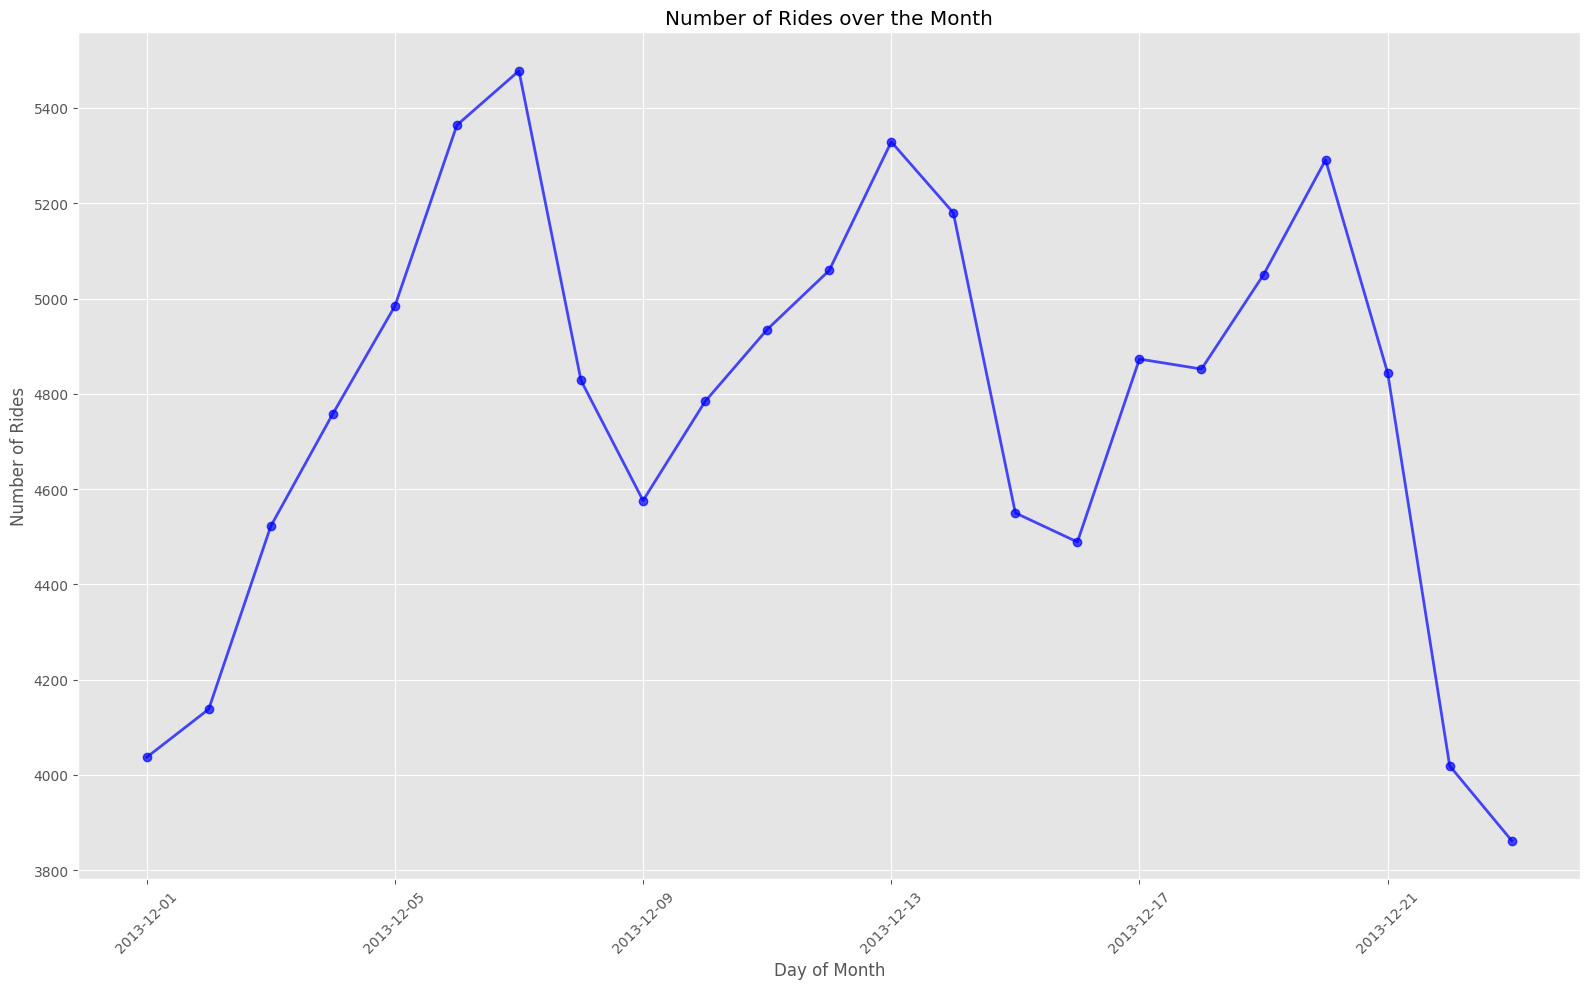

In [16]:
# Ensure that the 'date' column is in datetime format
df2['date'] = pd.to_datetime(df2['date'])

# Group by date and count the number of rides (assuming 'id' is the ride identifier)
daily_counts = df2.groupby(df2['date'].dt.date).count()['id']

# Plot the number of rides per day
plt.plot(daily_counts.index, daily_counts.values, 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
plt.show()

# Seasonal Adjustment with Differencing

Our time series contains weekly seasonal variation, which are cycles that repeat regularly over time.

In [17]:
# Group by date and count the number of rides (assuming 'id' is the ride identifier)
count = df2.groupby(df2['date'].dt.date).count()['id']

# Create a DataFrame with day and count, and set 'day' as the index
series = pd.DataFrame({'day': count.index, 'count': count.values}).set_index('day')

# Display the first few rows of the DataFrame
series.head()

,count
day,
2013-12-01,4037
2013-12-02,4138
2013-12-03,4522
2013-12-04,4758
2013-12-05,4984


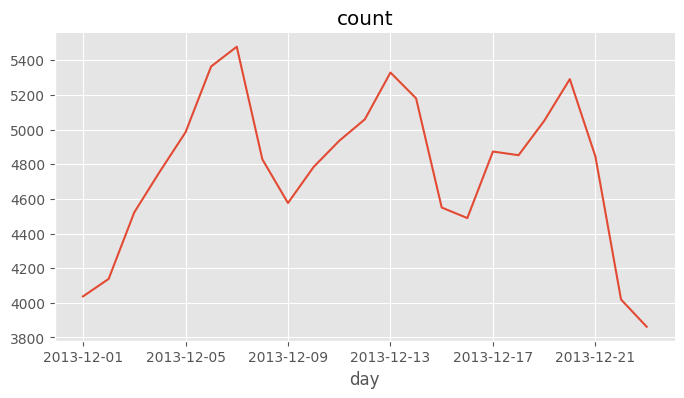

In [18]:
# @title count

from matplotlib import pyplot as plt
series['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

Since the weekly seasonality of our time series has been identified, it can be modeled.<br>
The model of seasonality can be removed from the time series. This process is called seasonal adjustment. <br>
A time series were the seasonal component has been removed is called seasonal stationary.<br>    

In the plot below, we consider that every month, there is a seasonal trend that repeats itself. We will take out the first month of values (becuase there is no prior month before that) and subtract the following values by the value of the number of rides of the day that came 30 days prior to it.

In [19]:
# Group by date and count the number of rides (assuming 'id' is the ride identifier)
count = df2.groupby(df2['date'].dt.date).count()['id']

# Create a DataFrame with day and count, and set 'day' as the index
series = pd.DataFrame({'day': count.index, 'count': count.values}).set_index('day')

# Display the first few rows of the DataFrame
series.head()

,count
day,
2013-12-01,4037
2013-12-02,4138
2013-12-03,4522
2013-12-04,4758
2013-12-05,4984


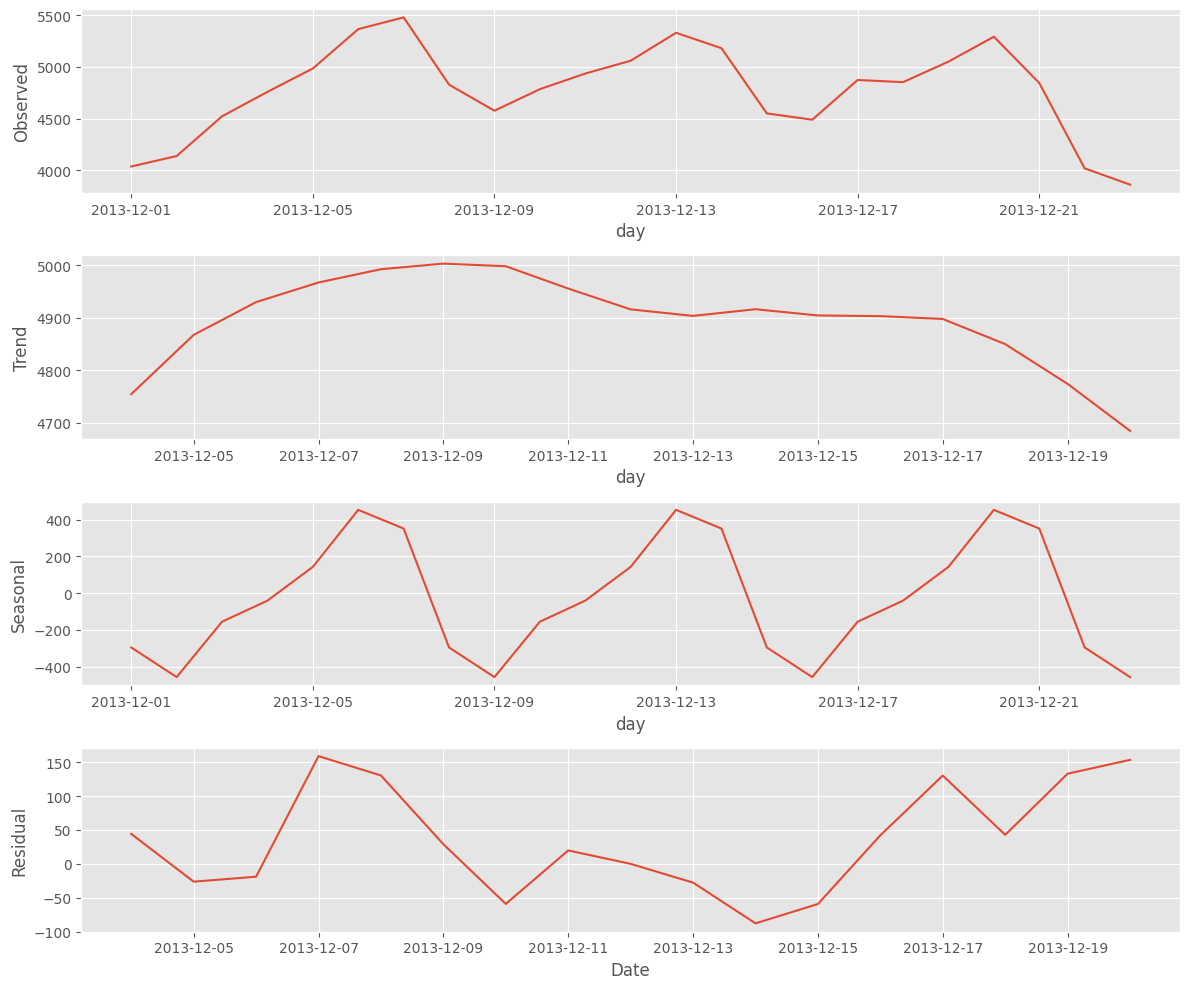

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform ETS decomposition with a weekly seasonality period
result_ets = seasonal_decompose(series['count'], model='add', period=7)

# Plot the decomposed components explicitly
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

result_ets.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result_ets.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result_ets.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result_ets.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.tight_layout()
plt.show()

The Error-Trend-Seasonality graph above shows information regarding the following components:

- Observed time series
- Trend: Reflects long term progression of series
- Seasonality: Reflects seasonal variation and checks if seasonal pattern exists in the time series
- Residual: Shows irregular component (or "noise") at time t, which describes random, irregular influences

While the trend is hard to pin down (especially because of the one anomalous dip in count) we can see that there is a strong weekly seasonal component in the time sries shown above. The residuals also show us that the dip in count on Jan. 23rd should be considered as an anomaly.


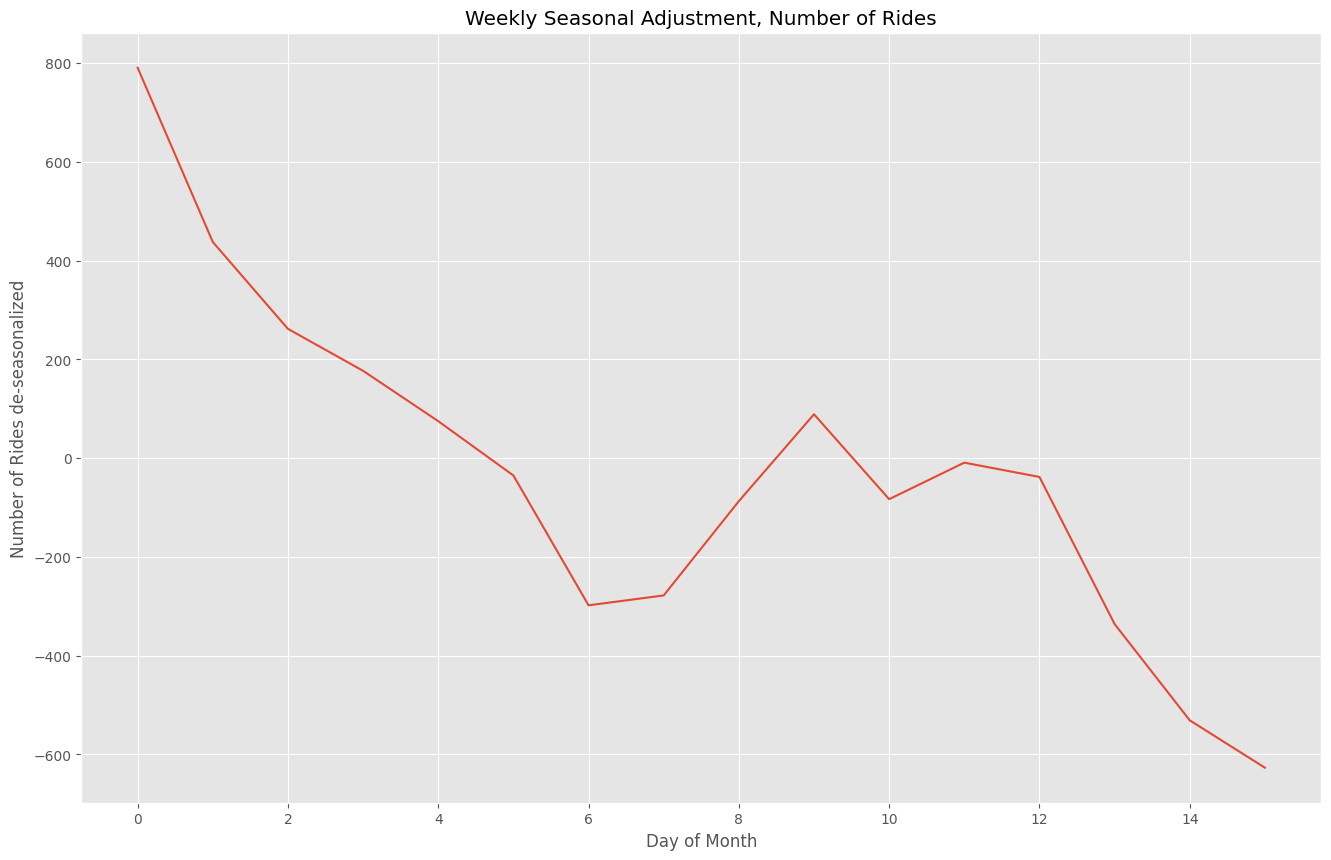

In [21]:
# Differencing by week for seasonal adjustment
X = series['count'].values
diff = list()
days_in_week = 7
for i in range(days_in_week, len(X)):
    value = X[i] - X[i - days_in_week]
    diff.append(value)

# Plot the differenced values
plt.plot(diff)
plt.xlabel('Day of Month')
plt.ylabel('Number of Rides de-seasonalized')
plt.title('Weekly Seasonal Adjustment, Number of Rides')
plt.show()

We can also consider the number fo rides within any given period of the year is probably stable. We can take this idea and consider all number of rides within a week to be stable. We can then subtract the average weekly number of rides from the previous week.

Resample the dataset to a weekly average:

                  count
day                    
2013-12-01  4037.000000
2013-12-08  4867.428571
2013-12-15  4916.142857
2013-12-22  4774.000000


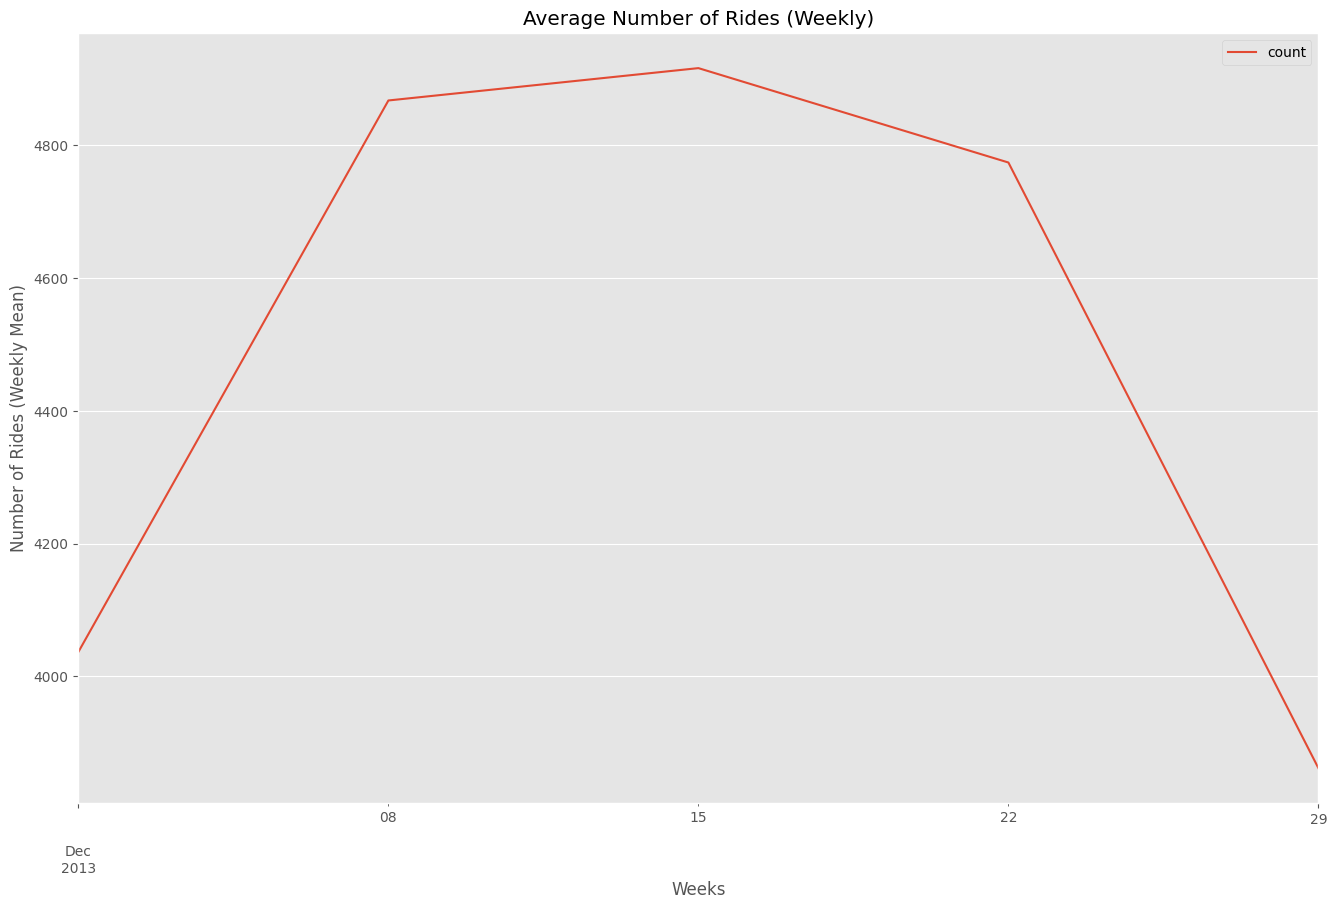

In [22]:
# Convert 'day' to DatetimeIndex
series.index = pd.to_datetime(series.index)

# Resample the series to get the weekly mean
weekly_mean = series.resample('W').mean()

# Display the first few rows of the weekly mean
print(weekly_mean.head(4))  # Adjusted to show up to 4 weeks (since it's one month)

# Plot the weekly mean
weekly_mean.plot()
plt.xlabel('Weeks')
plt.ylabel('Number of Rides (Weekly Mean)')
plt.title('Average Number of Rides (Weekly)')
plt.show()


The above plot shows a new seasonaly adjusted weekly average number of rides, skipping the first four weeks of data in order to create the adjustment (We subtract the weekly mean value of our adjustment by the weekly mean value of the data 4 weeks prior)

We can use the weekly average number of rides data to make this adjustment to the daily vlaues. The first week of values has been skipped (since they dont have a previous week of values to average and subtract by), and the rest of the values were subtracted by the average values of the number of rides of the 7 days prior to that day. This type of differencing makes the dataset more robust to daily fluctuations. It can be improved upon by using other metrics, such as previous month's mean, etc.

Here, we skipped the first month of data, averaged the previous month of number of rides, and then subtracted the value from the following days' number of rides.

# Seasonal Adjustment with Modeling

We can model the seasonal component directly as a sine wave over a generally fixed period and amplitude. We can choose a single week/month of data, or all of the data. We could also smooth the observations using a moving average centered on each value.

When using np.polyfit(), a consistent sine wave can usually be modeled by using order 4 or 5.

In [23]:
count1 =  df2.groupby('date').count()['id']
series1 = pd.DataFrame(({'day': count1.index, 'count': count1.values}))
series1.head()

,day,count
0,2013-12-01,4037
1,2013-12-02,4138
2,2013-12-03,4522
3,2013-12-04,4758
4,2013-12-05,4984


In [24]:
series1.index.shape

(23,)

In [25]:
import numpy.polynomial.polynomial as poly

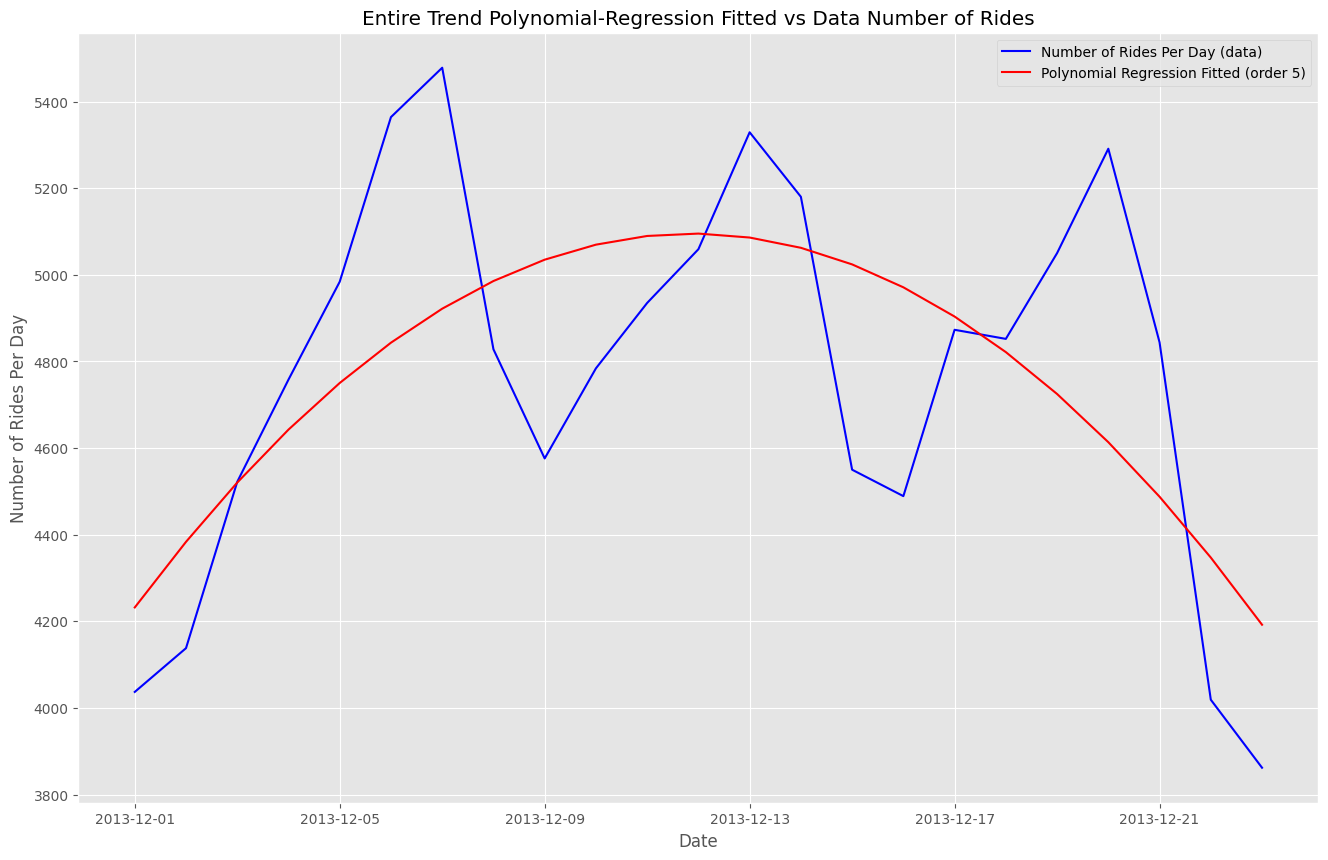

In [26]:
# Ensure 'series1' has a DatetimeIndex
if not isinstance(series1.index, pd.DatetimeIndex):
    series1['day'] = pd.to_datetime(series1['day'])
    series1.set_index('day', inplace=True)

# Convert the index to numeric (day of the year) for polynomial fitting
numeric_index = series1.index.map(pd.Timestamp.to_julian_date)

# Perform polynomial fitting
coefs = poly.polyfit(numeric_index, series1['count'], 5)
ffit = poly.polyval(numeric_index, coefs)

# Plot the results
plt.plot(series1.index, series1['count'], color='blue', label='Number of Rides Per Day (data)')
plt.plot(series1.index, ffit, color='red', label='Polynomial Regression Fitted (order 5)')
plt.xlabel('Date')
plt.ylabel('Number of Rides Per Day')
plt.title('Entire Trend Polynomial-Regression Fitted vs Data Number of Rides')
plt.legend()
plt.show()

# np.polyfit cannot fit the regression line properly at the bigger scale, let's look at a week of increments, using the average values.

In [27]:
df2['dayofweek'] = df2['pickup_datetime'].dt.dayofweek

In [28]:
print('Tootal weeks in the duration of the time series : %i' %(len(series)/7))

Tootal weeks in the duration of the time series : 3


In [29]:
count2 =  df2.groupby('dayofweek').count()['id']
series2 = pd.DataFrame(({'day': count2.index, 'count': count2.values / 26}))
series2.head()

,day,count
0,0,656.346154
1,1,545.346154
2,2,559.423077
3,3,580.500000
4,4,614.769231


In [30]:
x_new1 =  series2.index.copy()

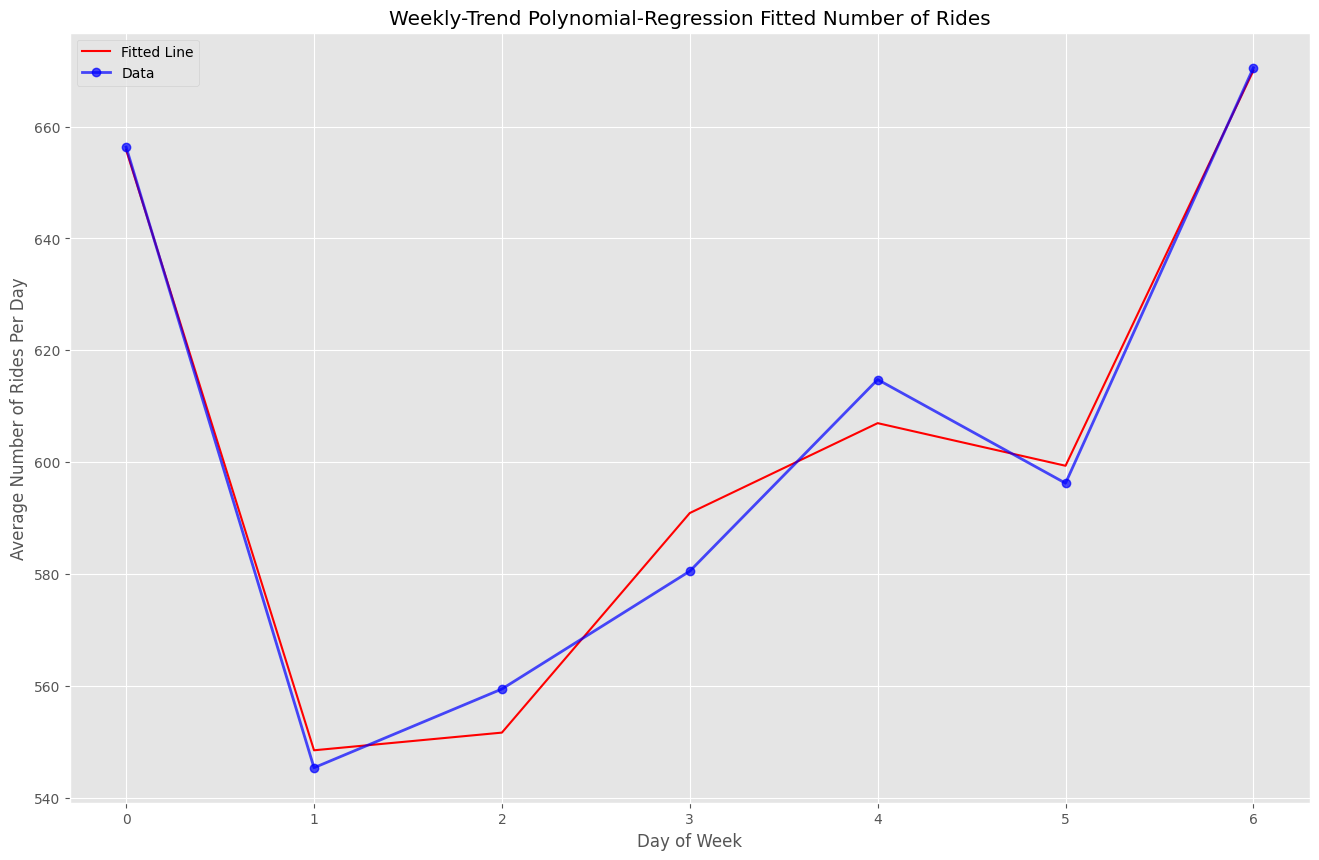

In [31]:
# Perform polynomial fitting
coefs = poly.polyfit(series2.index, series2['count'], 5)
ffit = poly.polyval(x_new1, coefs)

# Plot the fitted line and the original data
plt.plot(x_new1, ffit, color='red', label='Fitted Line')
plt.plot(series2['day'], series2['count'], 'bo-', lw=2, alpha=0.7, label='Data')
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression Fitted Number of Rides')
plt.show()

In [32]:
#ffit = poly.Polynomial(coefs)    # instead of np.poly1d
#plt.plot(x_new1, ffit(x_new1))

# Create a dataframe of the indexed day of weeks and the fitted average count values

In [33]:
deseason = pd.DataFrame(({'dayofweek': x_new1 , 'fitted_count': ffit}))
deseason.head(7)


,dayofweek,fitted_count
0,0,655.826340
1,1,548.465035
2,2,551.625874
3,3,590.896270
4,4,606.972028
5,5,599.349650
6,6,670.018648


In [34]:
count1 =  df2.groupby('date').count()['id']
final = pd.DataFrame(({'day': count1.index, 'count': count1.values}))

# Create a day of week column for a dataset that contains the entire data from January to June

In [35]:
final['dayofweek'] = final['day'].dt.dayofweek

In [36]:
final.head(10)

,day,count,dayofweek
0,2013-12-01,4037,6
1,2013-12-02,4138,0
2,2013-12-03,4522,1
3,2013-12-04,4758,2
4,2013-12-05,4984,3
5,2013-12-06,5364,4
6,2013-12-07,5478,5
7,2013-12-08,4828,6
8,2013-12-09,4576,0
9,2013-12-10,4784,1


# Merge such that the final dataframe will contain both the actual count values for each day, and the corresponding fitted polynomial values for the day of week value resides in

In [37]:
final_df2 = pd.merge(final,
                    deseason[['dayofweek', 'fitted_count']],
                    left_on = 'dayofweek',
                    right_on = 'dayofweek',
                    how = 'left')


In [38]:
final_df2['final_count'] = (round(final_df2['count'] - final_df2['fitted_count']))

In [39]:
final_df2.head(10)

,day,count,dayofweek,fitted_count,final_count
0,2013-12-01,4037,6,670.018648,3367.0
1,2013-12-02,4138,0,655.826340,3482.0
2,2013-12-03,4522,1,548.465035,3974.0
3,2013-12-04,4758,2,551.625874,4206.0
4,2013-12-05,4984,3,590.896270,4393.0
5,2013-12-06,5364,4,606.972028,4757.0
6,2013-12-07,5478,5,599.349650,4879.0
7,2013-12-08,4828,6,670.018648,4158.0
8,2013-12-09,4576,0,655.826340,3920.0
9,2013-12-10,4784,1,548.465035,4236.0


# Plot the resulting weekly trend polynomial-regression subtracted deseasonalized data.

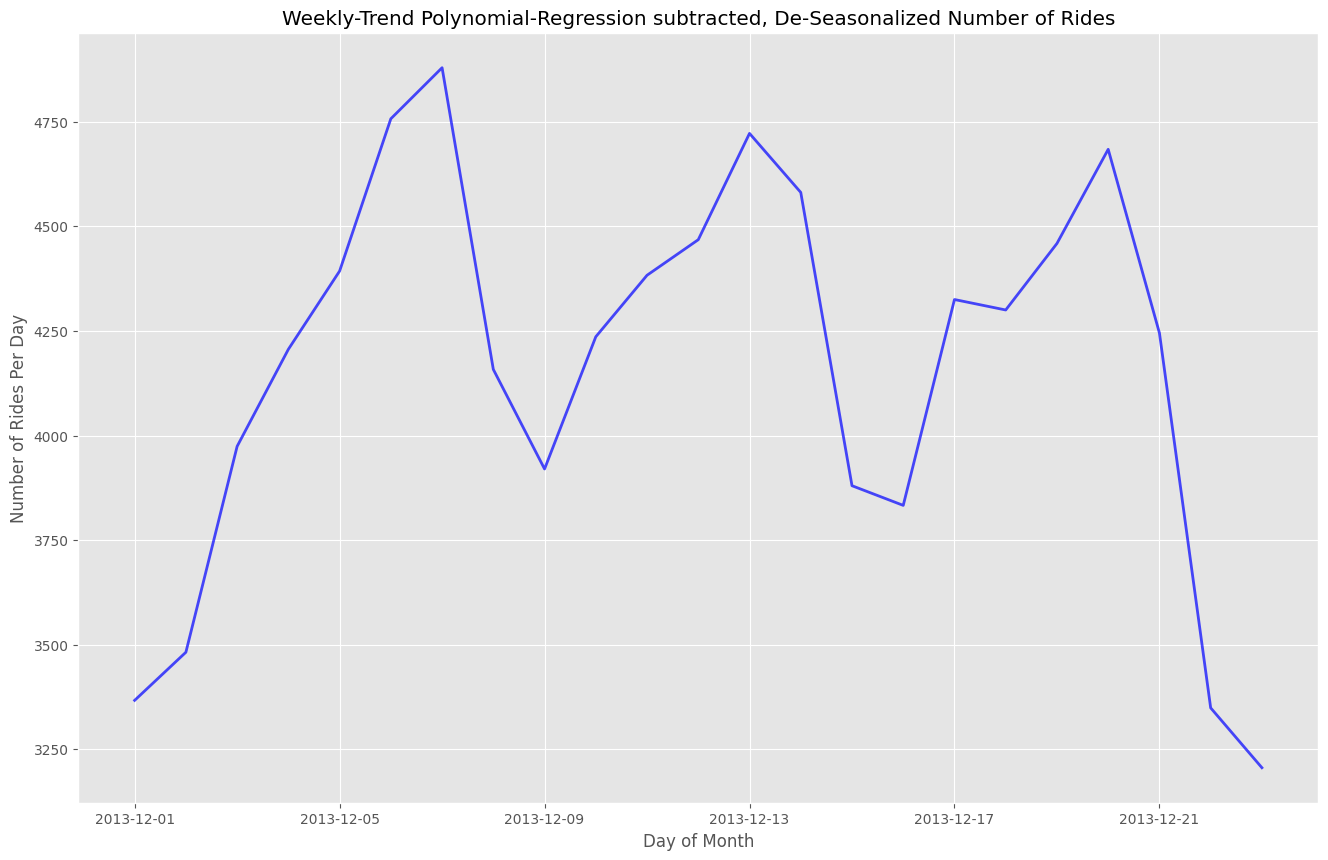

In [40]:
plt.plot(final_df2.day, final_df2.final_count , 'b-', lw=2, alpha=0.7)
plt.xlabel('Day of Month')
plt.ylabel('Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression subtracted, De-Seasonalized Number of Rides')
plt.show()

Get rid of January data, to see if De-Seasaonalizing by weekly trends worked.

In [41]:
# Remove the data around January 21st to clean the dataset
start_date = '2013-12-18'
end_date = '2013-12-22'
final_df2_cleaned = final_df2[(final_df2['day'] < start_date) | (final_df2['day'] > end_date)]

In [42]:
final_df2_cleaned.columns

Index(['day', 'count', 'dayofweek', 'fitted_count', 'final_count'], dtype='object')

In [43]:
df2 = final_df2_cleaned[['day', 'final_count']]

In [44]:
df2.set_index('day', inplace = True)
df2.index = pd.RangeIndex(len(df2.index))
df2.head()

,final_count
0,3367.0
1,3482.0
2,3974.0
3,4206.0
4,4393.0


In [45]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(df2['final_count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

,Value,Label
0,-1.865926,Test Statistic
1,0.672137,p-value
2,3.000000,#Lags Used
3,14.000000,Number of Observations Used
4,-4.799351,Critical value for 1%
5,-3.786728,Critical value for 5%
6,-3.339917,Critical value for 10%


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Rejecting that there is a unit root -> time series is stationary

Since the pvalue is extremely close to 0, we can reject the null hypothesis and assume that the weekly seasonality transformation of the time series has detrended the data significantly enough that it can be considered as stationary.

In [46]:
# Define the tsplot function
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [47]:
num_lags = min(20, len(df2) // 2 - 1)

(<Axes: title={'center': 'De-Trended Time Series'}>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

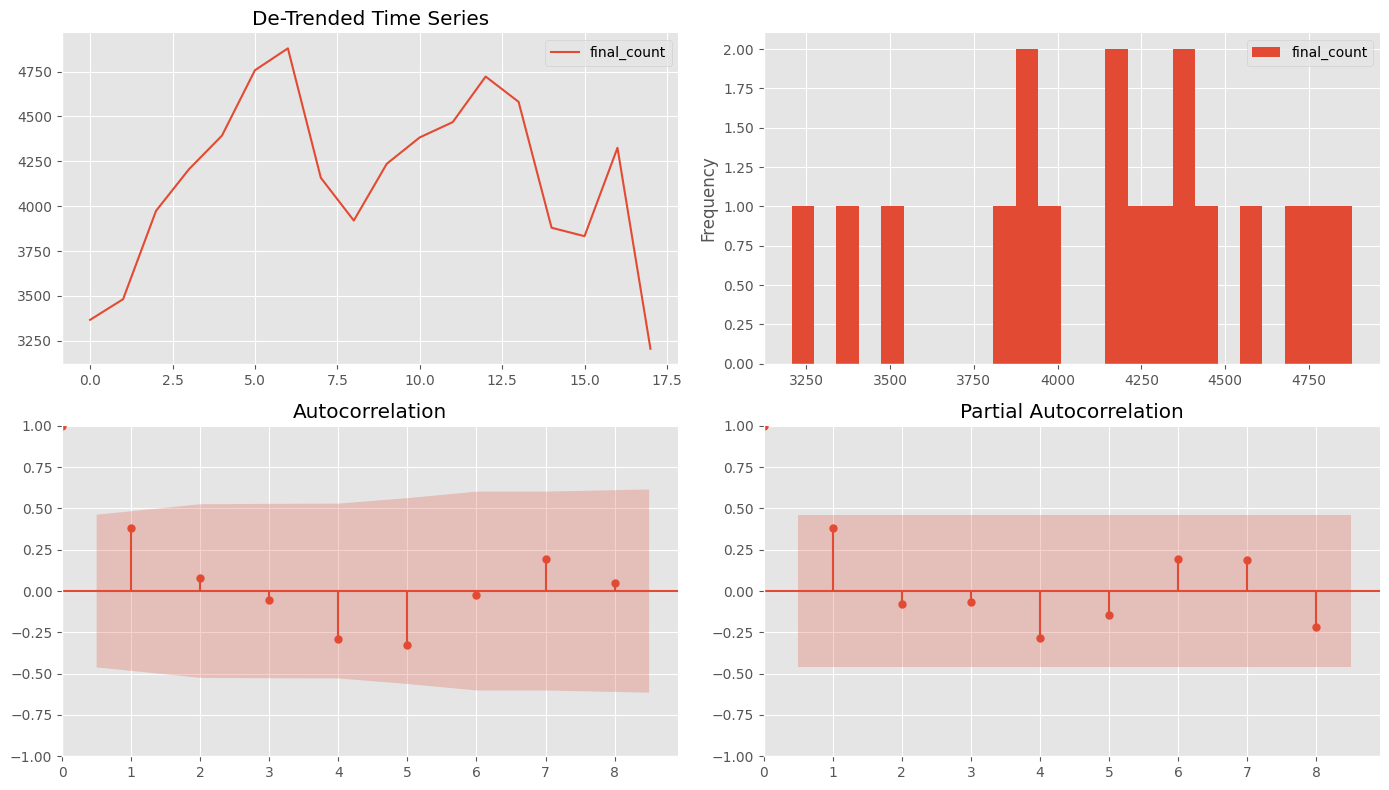

In [48]:
tsplot(df2, title='De-Trended Time Series', lags=num_lags)

**ARIMA model determination**

The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |

Looking at the subplots above, it may be wise to use the AR models since it best describes our time series behavior. This is all theoretical however, and the best model may also not end up being an autoregressive model.

# Seasonal ARIMA Modelling

We can use the statsmodel's SARIMAX function to model a seasonal arima model on our dataset by prescribing a set of p,d,q variables. Calling the summary method on the fitted model then gives information about the fitted model including information criterion such as AIC and BIC.

We will also take the first 90% of the dataset as our prediction values, and leave out the most recent 10% of the dataset as the prediction (test) values. We dont want to take a random split of training and test datas because in this time series, we want to see how well we can predict our out of sample "future" values for ride demand.

In [49]:
n_sample = df2.shape[0]
print('New length of the entire dataset is : %i' %n_sample)

New length of the entire dataset is : 18


In [50]:
n_train=int(0.90*n_sample) + 1
n_forecast=n_sample-n_train

ts_train = df2.iloc[:n_train]['final_count']
ts_test = df2.iloc[n_train:]['final_count']

In [51]:
print(('Number of in sample training dataset : %i' %len(ts_train)))
print(('Number of out of sample testing dataset : %i' %len(ts_test)))

Number of in sample training dataset : 17
Number of out of sample testing dataset : 1


Including seasonal_order with the AR and MA component and period of 7 days (weekly).
Simple differencing is set to true such that we can forecast and calculate the error values later on the held out "future" data


In [52]:
arima101 = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,1), seasonal_order= (1,0,1,7), simple_differencing=True)
model_results = arima101.fit()
model_results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       final_count   No. Observations:                   17
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -115.445
Date:                           Tue, 24 Sep 2024   AIC                            240.890
Time:                                   18:13:03   BIC                            245.056
Sample:                                        0   HQIC                           241.304
                                            - 17                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9565      0.104      9.166      0.000       0.752       1.161
ma.L1          0.7613      0.384      1.982      0.048       0.008       1.514
ar.S.L7        0.9918      0.051     19.292      0.000       0.891       1.093
ma.S.L7       -0.6791      0.939     -0.723      0.470      -2.520       1.162
sigma2      1.262e+04   1.09e+04      1.155      0.248   -8792.422     3.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.43   Prob(JB):                         0.72
Heteroskedasticity (H):               0.49   Skew:                            -0.36
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The following function will gather the BIC metric given a set of p,d,q values to try out.

In [53]:
#credit to Jeffery Yau @ https://www.youtube.com/watch?v=tJ-O3hk1vRwhttps://www.youtube.com/watch?v=tJ-O3hk1vRw
#PyData SF2016 conference

import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue

    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

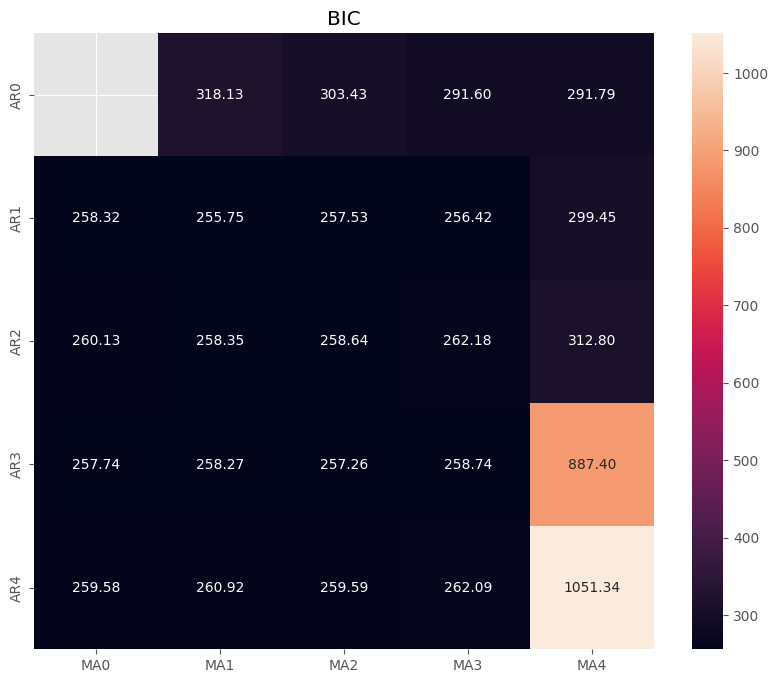

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

Plotting the above function as a heatmap, we can see that AR 1 and MA 0 gives us the lowest BIC measure out of all of the different combinations of input variables.

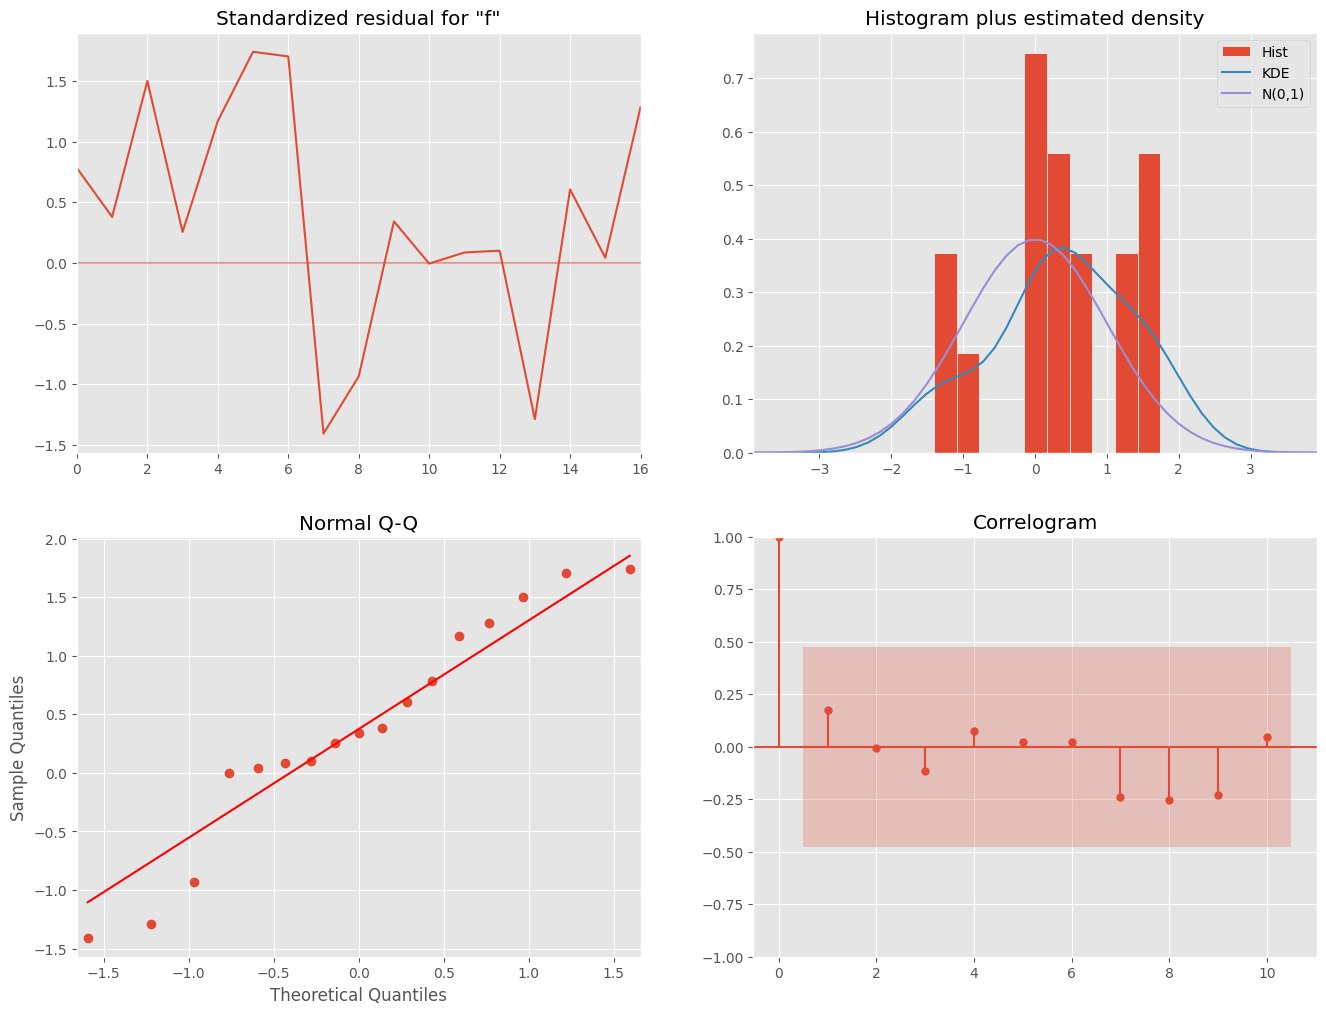

In [55]:
model_results.plot_diagnostics(figsize=(16, 12));

Finally, using the plot_diagnostic method on the model defined with AR 1 and MA 1 order components, we can see features such as residuals, histogram, normality, and correlogram.

For the most part, from looking at the plot distributions of the residuals from the SARIMAX model, we can see that the residuals look scattered around zero, and are roughly normally distributed when looking at the histogram and the linear fit. The correlation values mostly stay within the 95% confidence range as well.

By taking out the first 25 days of values, we have effectively made our dataset more normally pleasant.

In [56]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=0.494, p=0.412

Test normality of residuals (jarquebera): stat=0.653, p=0.721

Test serial correlation of residuals (ljungbox): stat=0.939, p=0.816

Durbin-Watson test on residuals: d=1.36
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


Judging by the results of the statistics tests carried out above, we can conclude the following:

- The null hypothesis is of no heteroskedasticity is not rejected.
- The test for normality of standardized residuals is not rejected. ($\alpha = 0.01$)
- The Jung-box test for no serial correlation of standardized residuals is not rejected
- The Durbin-Watson test also shows no serial correlation as the value is near 2
- Both the AR and MA roots are outside of the unit circle, suggesting that our model has achieved invertibility

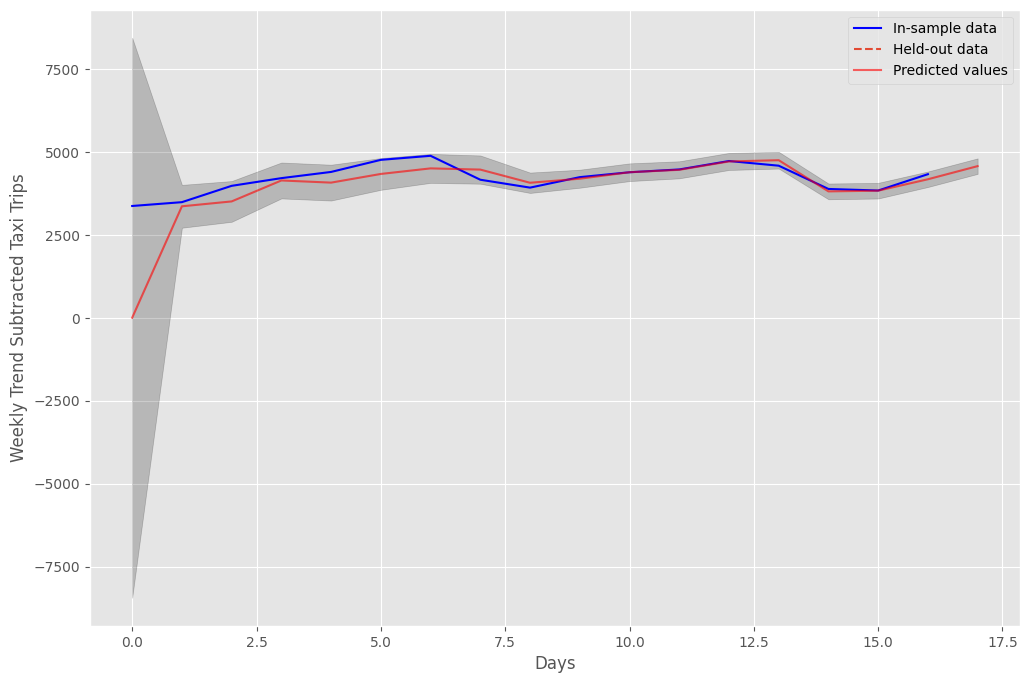

In [57]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax1.plot(ts_train, color = 'blue', label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin,
                                    end=pred_end)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.xlabel('Days')
plt.ylabel('Weekly Trend Subtracted Taxi Trips')
ax1.legend(loc='best');

In [58]:
def get_rmse(y, y_hat):

    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

In [59]:
rmse1 = get_rmse(ts_train, pred_mean.iloc[ts_train.index])
print("In sample RMSE: %.4f" % rmse1)

rmse2 = get_rmse(ts_test, pred_mean.iloc[-15:])
print("Out of Sample forecast RMSE: %.4f" % rmse2)


In sample RMSE: 846.4217
Out of Sample forecast RMSE: 1361.6915


With our SARIMAX model, we achieve an in sample RMSE error value of 300, while we achieve an out of sample forecast RMLSE of 490. While our forecast model was only 15 data samples, we get a promising error metric, when considering that there are more than 7 thousand trips on average given any day in NYC.

Now, let's merge back into our original dataframe, so that we can reapply the weekly trends, and get the final transformed predictions on top of the original time series data.

In [60]:
pred_df = pd.DataFrame({'pred_count': pred_mean})

In [61]:
final_df2_cleaned.index = pd.RangeIndex(len(final_df2_cleaned.index))
final_df2_cleaned.head()

,day,count,dayofweek,fitted_count,final_count
0,2013-12-01,4037,6,670.018648,3367.0
1,2013-12-02,4138,0,655.826340,3482.0
2,2013-12-03,4522,1,548.465035,3974.0
3,2013-12-04,4758,2,551.625874,4206.0
4,2013-12-05,4984,3,590.896270,4393.0


In [62]:
result_df = final_df2_cleaned.join(pred_df, how ='outer')
result_df['pred_fit'] = result_df['fitted_count'] + result_df['pred_count']
result_df.head()

,day,count,dayofweek,fitted_count,final_count,pred_count,pred_fit
0,2013-12-01,4037,6,670.018648,3367.0,0.000000,670.018648
1,2013-12-02,4138,0,655.826340,3482.0,3357.125400,4012.951740
2,2013-12-03,4522,1,548.465035,3974.0,3504.309792,4052.774827
3,2013-12-04,4758,2,551.625874,4206.0,4135.587320,4687.213194
4,2013-12-05,4984,3,590.896270,4393.0,4070.676109,4661.572379


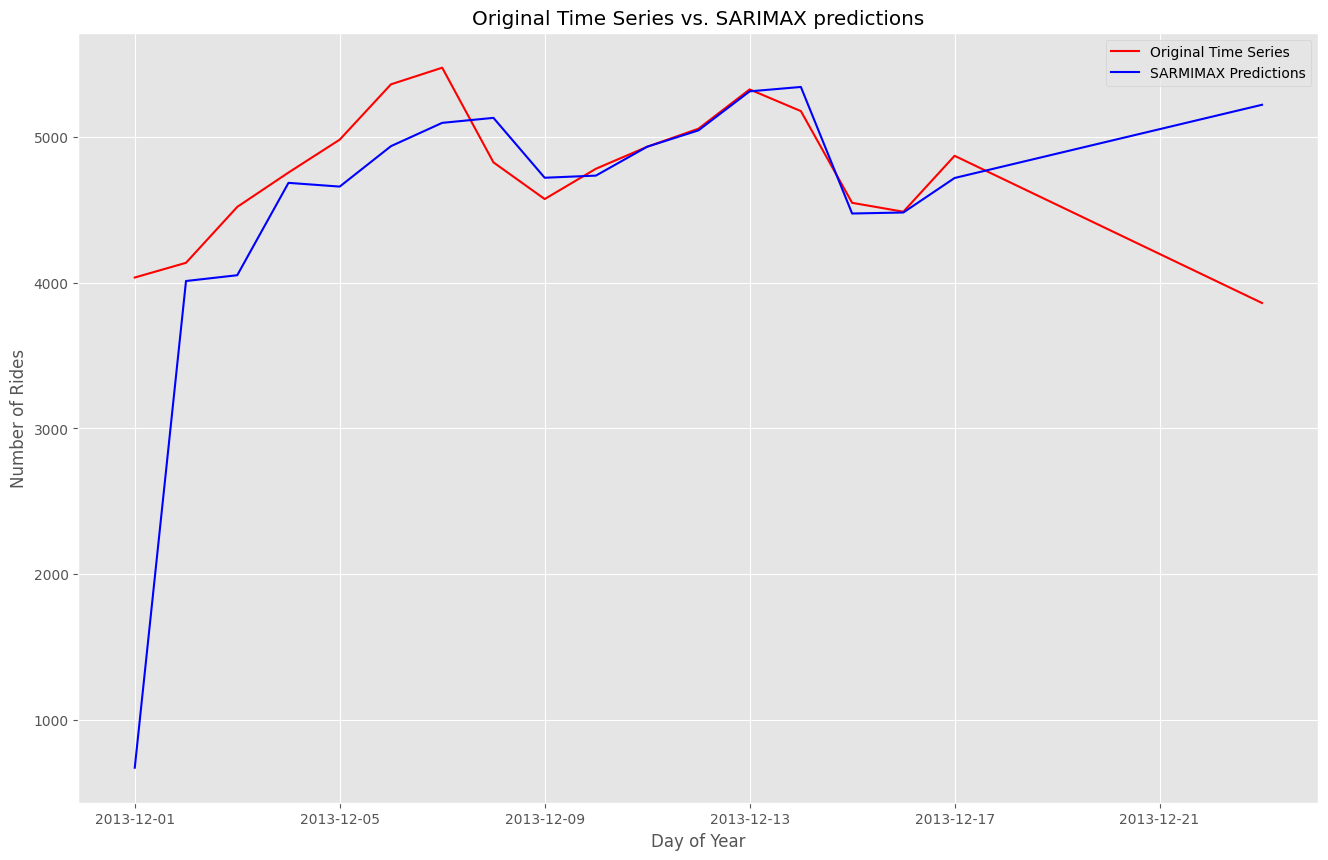

In [63]:
plt.plot(result_df['day'], result_df['count'], color = 'red', label = 'Original Time Series')
plt.plot(result_df['day'], result_df['pred_fit'], color = 'blue', label = 'SARMIMAX Predictions')
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Original Time Series vs. SARIMAX predictions')
plt.legend()
plt.show()

Finally, by looking at the above chart, we can see that the RMSE error of around 300 cars per day was not a bad measure at all. Our SARMIX model was able to fairly accurately predict the model and its weekly seasonality.

# During Chirstmas

In [64]:
df3['pickup_datetime'] = pd.to_datetime(df3.pickup_datetime)
df3['date'] = df3['pickup_datetime'].dt.date

In [65]:
#some datetime manipulations
df3['dropoff_datetime'] = pd.to_datetime(df3.dropoff_datetime)

In [66]:
df3['Hour'] = df3['pickup_datetime'].dt.hour
df3['dayofweek'] = df3['pickup_datetime'].dt.dayofweek
df3['Month'] = df3['pickup_datetime'].dt.month
df3['dayofyear'] = df3['pickup_datetime'].dt.dayofyear

In [67]:
df3

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date,Hour,dayofweek,Month,dayofyear
6242140,B1E9187878D73A574ADE63C23946C222,D325B18850F1397D61EF1201EBDABF88,CMT,1,N,2013-12-26 18:33:16,2013-12-26 18:37:59,2,283,1.20,0.000000,0.000000,0.000000,0.000000,2013-12-26,18,3,12,360
6811194,60A304E43B5B42CDE4DE2327311F98D3,1892CF492051A673AEE823656D866A3F,CMT,1,N,2013-12-31 21:04:31,2013-12-31 21:11:47,1,436,1.00,-73.993553,40.735226,-73.991211,40.737648,2013-12-31,21,1,12,365
5434718,C64FCD3188AB6F642022AD1EEC3BDD38,EF1A40FB38B22449ED7EC323FDF9DDB4,VTS,1,NaN,2013-12-27 12:47:00,2013-12-27 13:02:00,6,900,1.55,-73.985298,40.735767,-73.994736,40.750416,2013-12-27,12,4,12,361
5036450,E686580C1A4A1EB60286F0F0BE98B247,3308B2E004FEA58DD086AEFFD4859502,VTS,1,NaN,2013-12-28 13:00:00,2013-12-28 13:07:00,1,420,0.17,-73.997986,40.740959,-73.995995,40.758690,2013-12-28,13,5,12,362
5432915,1EB647AF151777C472FF673CA2A7ECF7,31446059FEC3F4F50B23DF4F19D5EED6,CMT,1,N,2013-12-25 17:42:22,2013-12-25 17:50:49,3,506,2.20,-73.978798,40.787483,-73.990883,40.760693,2013-12-25,17,2,12,359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766049,3376CC491DCC286E0B767CBF1B3BB701,A94BDD499E993B2729D5C071079CD338,CMT,1,N,2013-12-28 07:46:41,2013-12-28 08:00:46,1,845,5.00,-73.972816,40.677578,-73.975441,40.741116,2013-12-28,7,5,12,362
5152228,A4DD6487D0DE6EE5A7CC92A510CD50F3,E2012AE51E1DB54CE7D7A99C3E8FFE3A,VTS,1,NaN,2013-12-27 11:13:00,2013-12-27 11:18:00,2,300,0.92,-74.005508,40.725697,-74.002731,40.733593,2013-12-27,11,4,12,361
6773081,037673EEAE0DCB912D06BED04E89D89D,3BE2C6BCC74E7099207A4FE1AE88756C,CMT,1,N,2013-12-31 14:56:29,2013-12-31 15:28:08,1,1899,13.50,-73.989960,40.752136,-73.827019,40.690105,2013-12-31,14,1,12,365
6533443,58D041723F762894E61E154F67AC6480,7AA4C9C190A0947D236A3FA0578A3195,CMT,1,N,2013-12-29 03:11:44,2013-12-29 03:14:23,1,159,0.90,-73.963829,40.690022,-73.981148,40.690006,2013-12-29,3,6,12,363


In [68]:
# Create a range of numbers for the ID column
id_values = range(1, len(df3) + 1)

# Assign the ID values to a new column called 'id'
df3['id'] = id_values

In [69]:
df3

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date,Hour,dayofweek,Month,dayofyear,id
6242140,B1E9187878D73A574ADE63C23946C222,D325B18850F1397D61EF1201EBDABF88,CMT,1,N,2013-12-26 18:33:16,2013-12-26 18:37:59,2,283,1.20,0.000000,0.000000,0.000000,0.000000,2013-12-26,18,3,12,360,1
6811194,60A304E43B5B42CDE4DE2327311F98D3,1892CF492051A673AEE823656D866A3F,CMT,1,N,2013-12-31 21:04:31,2013-12-31 21:11:47,1,436,1.00,-73.993553,40.735226,-73.991211,40.737648,2013-12-31,21,1,12,365,2
5434718,C64FCD3188AB6F642022AD1EEC3BDD38,EF1A40FB38B22449ED7EC323FDF9DDB4,VTS,1,NaN,2013-12-27 12:47:00,2013-12-27 13:02:00,6,900,1.55,-73.985298,40.735767,-73.994736,40.750416,2013-12-27,12,4,12,361,3
5036450,E686580C1A4A1EB60286F0F0BE98B247,3308B2E004FEA58DD086AEFFD4859502,VTS,1,NaN,2013-12-28 13:00:00,2013-12-28 13:07:00,1,420,0.17,-73.997986,40.740959,-73.995995,40.758690,2013-12-28,13,5,12,362,4
5432915,1EB647AF151777C472FF673CA2A7ECF7,31446059FEC3F4F50B23DF4F19D5EED6,CMT,1,N,2013-12-25 17:42:22,2013-12-25 17:50:49,3,506,2.20,-73.978798,40.787483,-73.990883,40.760693,2013-12-25,17,2,12,359,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5766049,3376CC491DCC286E0B767CBF1B3BB701,A94BDD499E993B2729D5C071079CD338,CMT,1,N,2013-12-28 07:46:41,2013-12-28 08:00:46,1,845,5.00,-73.972816,40.677578,-73.975441,40.741116,2013-12-28,7,5,12,362,59814
5152228,A4DD6487D0DE6EE5A7CC92A510CD50F3,E2012AE51E1DB54CE7D7A99C3E8FFE3A,VTS,1,NaN,2013-12-27 11:13:00,2013-12-27 11:18:00,2,300,0.92,-74.005508,40.725697,-74.002731,40.733593,2013-12-27,11,4,12,361,59815
6773081,037673EEAE0DCB912D06BED04E89D89D,3BE2C6BCC74E7099207A4FE1AE88756C,CMT,1,N,2013-12-31 14:56:29,2013-12-31 15:28:08,1,1899,13.50,-73.989960,40.752136,-73.827019,40.690105,2013-12-31,14,1,12,365,59816
6533443,58D041723F762894E61E154F67AC6480,7AA4C9C190A0947D236A3FA0578A3195,CMT,1,N,2013-12-29 03:11:44,2013-12-29 03:14:23,1,159,0.90,-73.963829,40.690022,-73.981148,40.690006,2013-12-29,3,6,12,363,59817


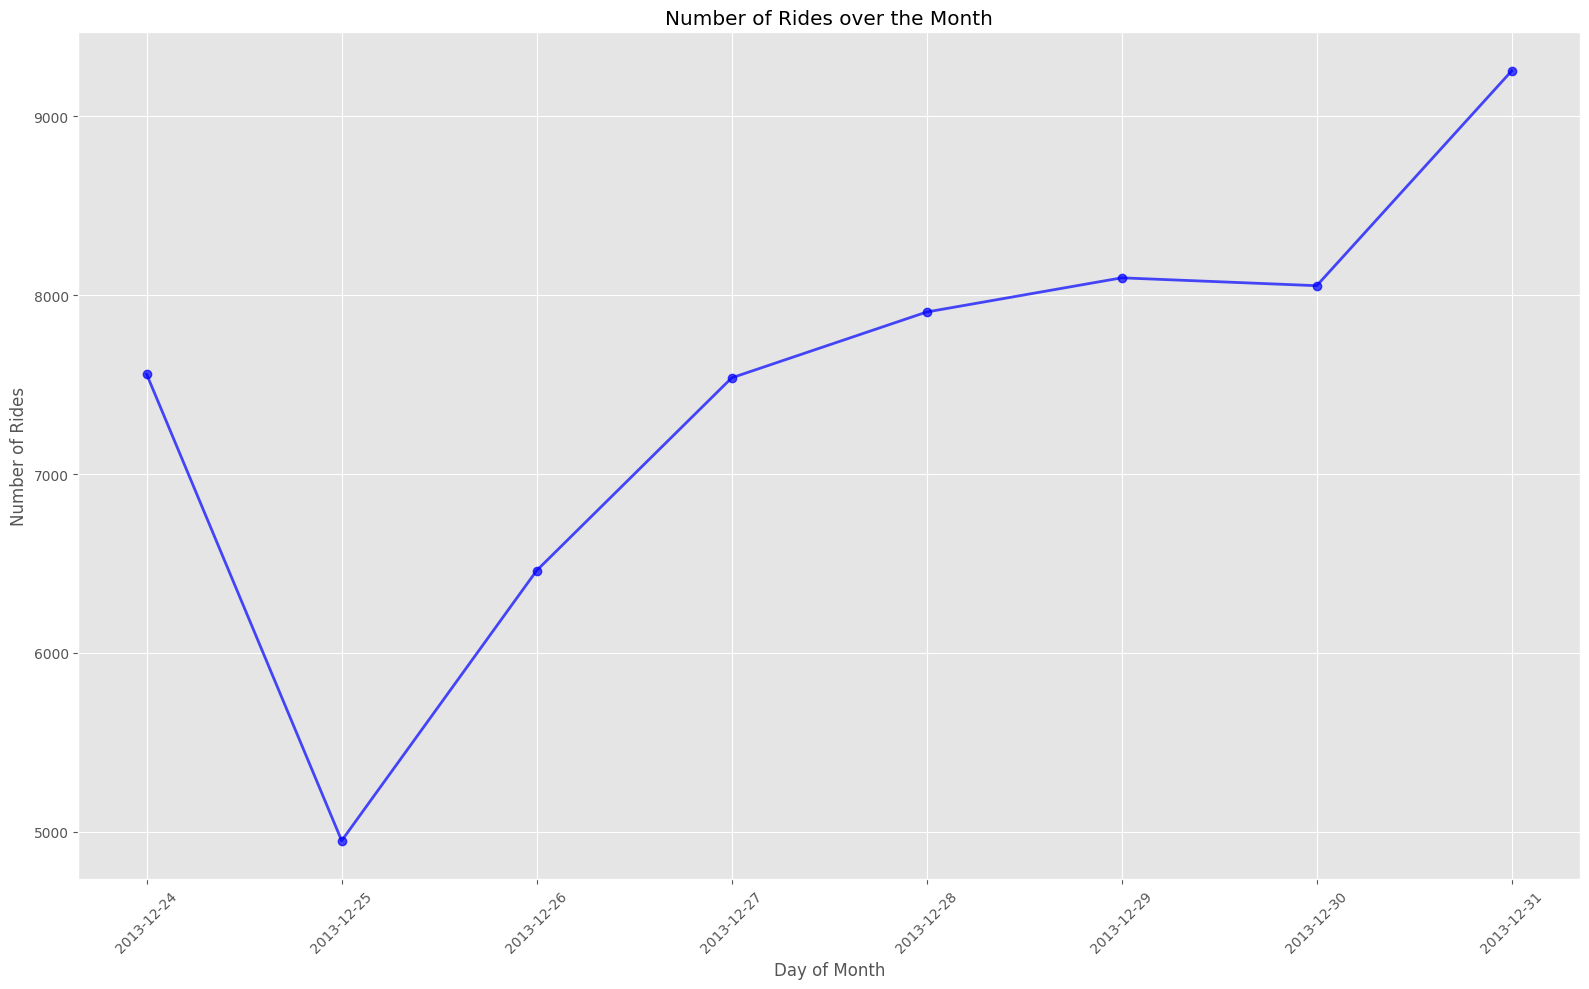

In [70]:
# Ensure that the 'date' column is in datetime format
df3['date'] = pd.to_datetime(df3['date'])

# Group by date and count the number of rides (assuming 'id' is the ride identifier)
daily_counts = df3.groupby(df3['date'].dt.date).count()['id']

# Plot the number of rides per day
plt.plot(daily_counts.index, daily_counts.values, 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
plt.show()

# Seasonal Adjustment with Differencing

In [71]:
# Group by date and count the number of rides (assuming 'id' is the ride identifier)
count = df3.groupby(df3['date'].dt.date).count()['id']

# Create a DataFrame with day and count, and set 'day' as the index
series2 = pd.DataFrame({'day': count.index, 'count': count.values}).set_index('day')

# Display the first few rows of the DataFrame
series2.head()

,count
day,
2013-12-24,7558
2013-12-25,4951
2013-12-26,6461
2013-12-27,7538
2013-12-28,7906


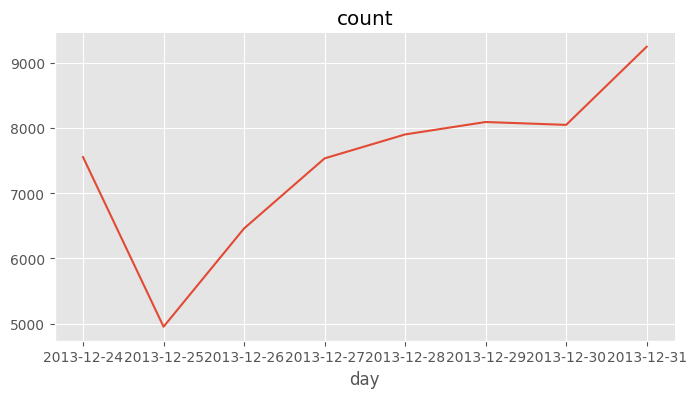

In [72]:
# @title count

from matplotlib import pyplot as plt
series2['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [73]:
# Group by date and count the number of rides (assuming 'id' is the ride identifier)
count2 = df3.groupby(df3['date'].dt.date).count()['id']

# Create a DataFrame with day and count, and set 'day' as the index
series2 = pd.DataFrame({'day': count.index, 'count': count.values}).set_index('day')

# Display the first few rows of the DataFrame
series2.head()

,count
day,
2013-12-24,7558
2013-12-25,4951
2013-12-26,6461
2013-12-27,7538
2013-12-28,7906


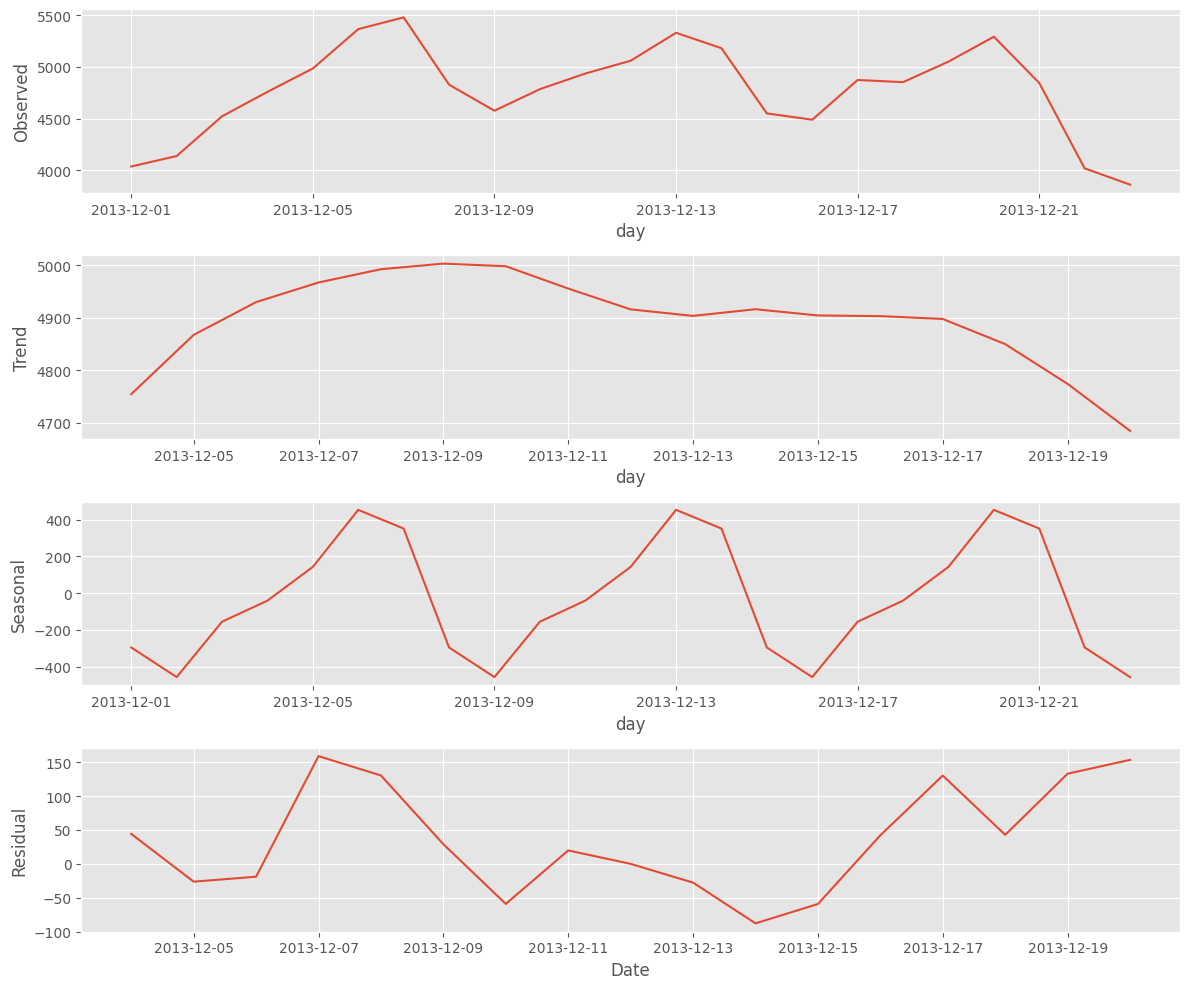

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform ETS decomposition with a weekly seasonality period
result_ets2 = seasonal_decompose(series['count'], model='add', period=4)

# Plot the decomposed components explicitly
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

result_ets.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result_ets.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result_ets.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result_ets.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.tight_layout()
plt.show()

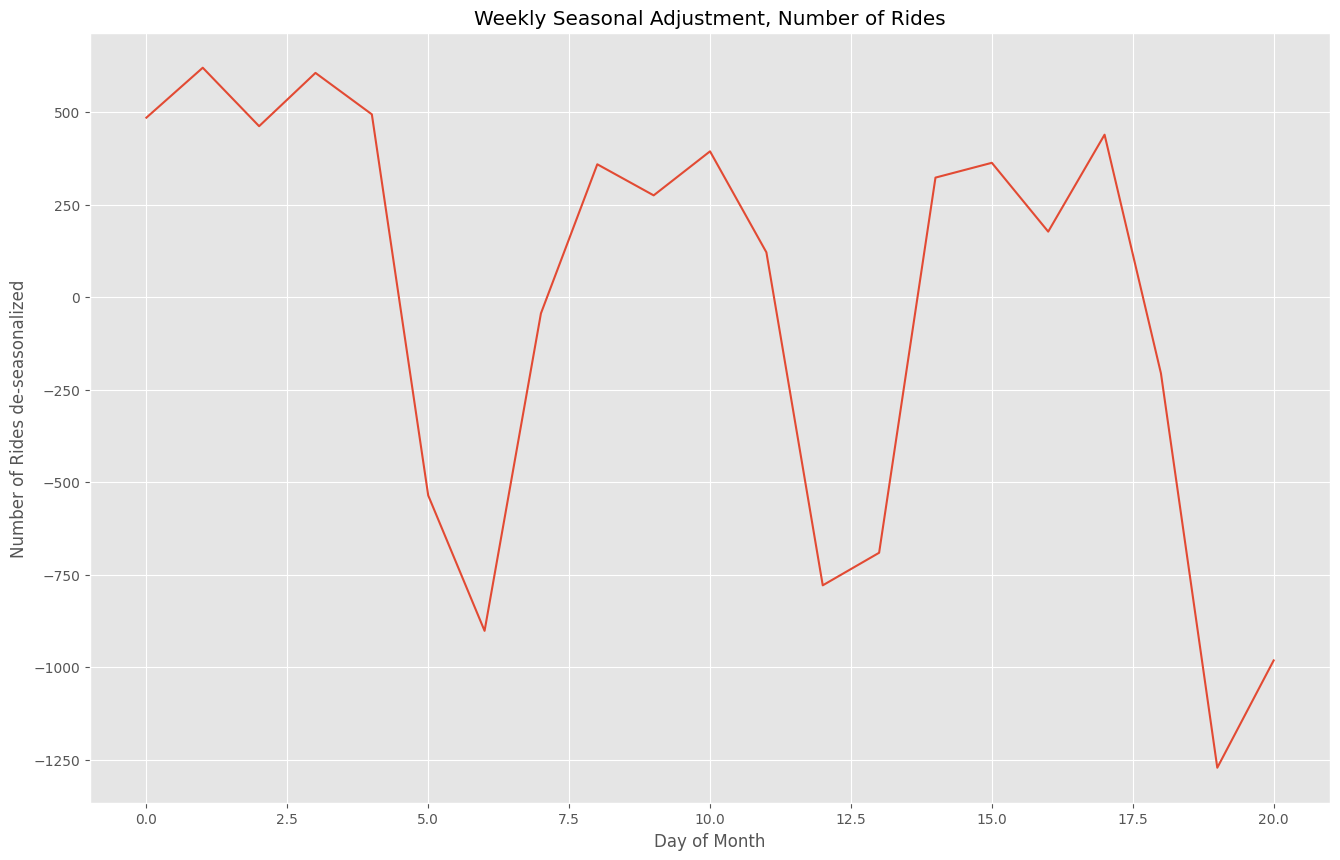

In [75]:
# Differencing by week for seasonal adjustment
X2 = series2['count'].values
diff = list()
days_in_week = 2
for i in range(days_in_week, len(X)):
    value = X[i] - X[i - days_in_week]
    diff.append(value)

# Plot the differenced values
plt.plot(diff)
plt.xlabel('Day of Month')
plt.ylabel('Number of Rides de-seasonalized')
plt.title('Weekly Seasonal Adjustment, Number of Rides')
plt.show()

                  count
day                    
2013-12-29  7085.166667
2014-01-05  8653.500000


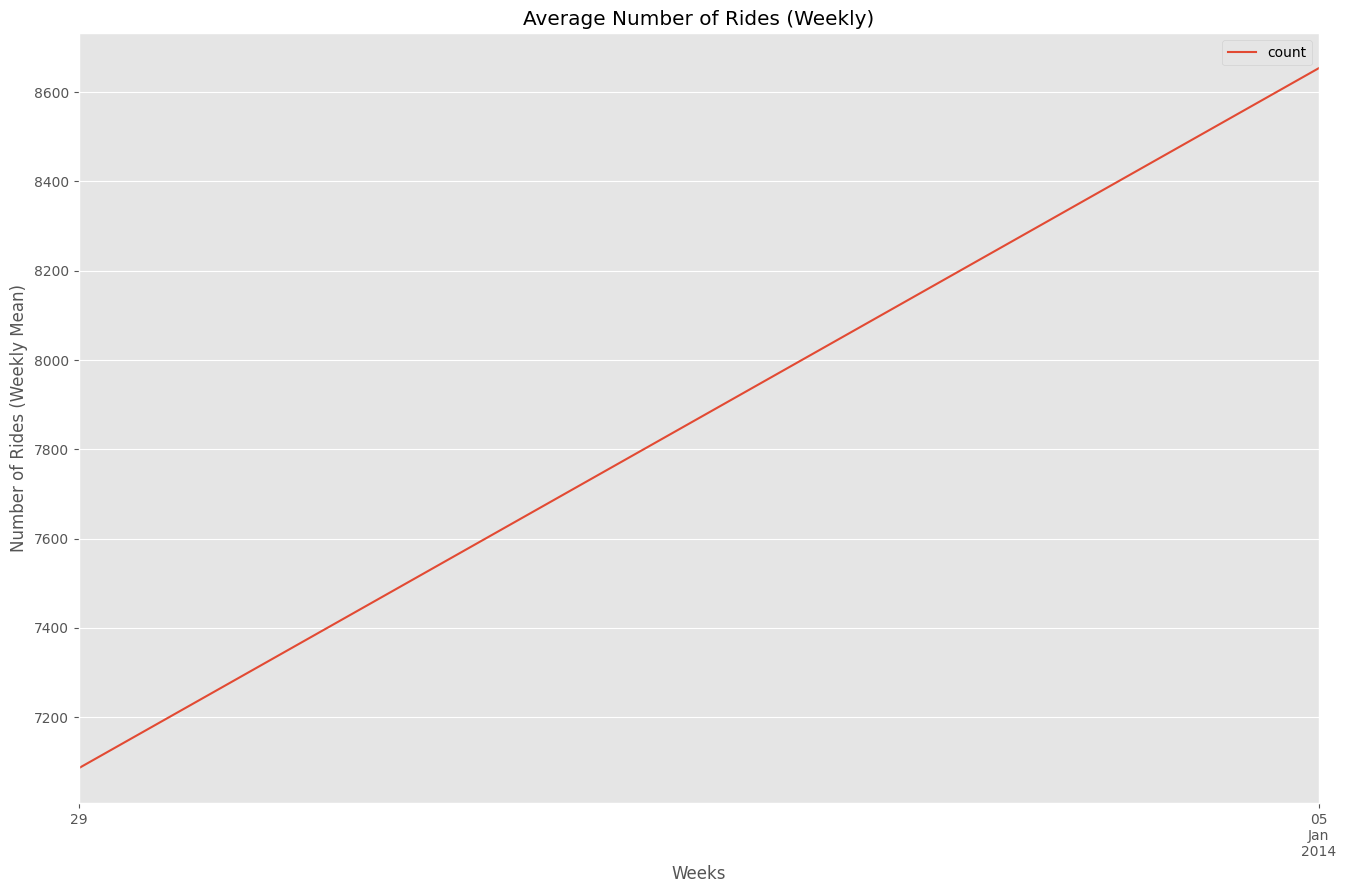

In [76]:
# Convert 'day' to DatetimeIndex
series2.index = pd.to_datetime(series2.index)

# Resample the series to get the weekly mean
weekly_mean = series2.resample('W').mean()

# Display the first few rows of the weekly mean
print(weekly_mean.head(4))  # Adjusted to show up to 4 weeks (since it's one month)

# Plot the weekly mean
weekly_mean.plot()
plt.xlabel('Weeks')
plt.ylabel('Number of Rides (Weekly Mean)')
plt.title('Average Number of Rides (Weekly)')
plt.show()


In [77]:
count3 =  df3.groupby('date').count()['id']
series3 = pd.DataFrame(({'day': count1.index, 'count': count1.values}))
series3.head()

,day,count
0,2013-12-01,4037
1,2013-12-02,4138
2,2013-12-03,4522
3,2013-12-04,4758
4,2013-12-05,4984


In [78]:
series3.index.shape

(23,)

In [79]:
import numpy.polynomial.polynomial as poly

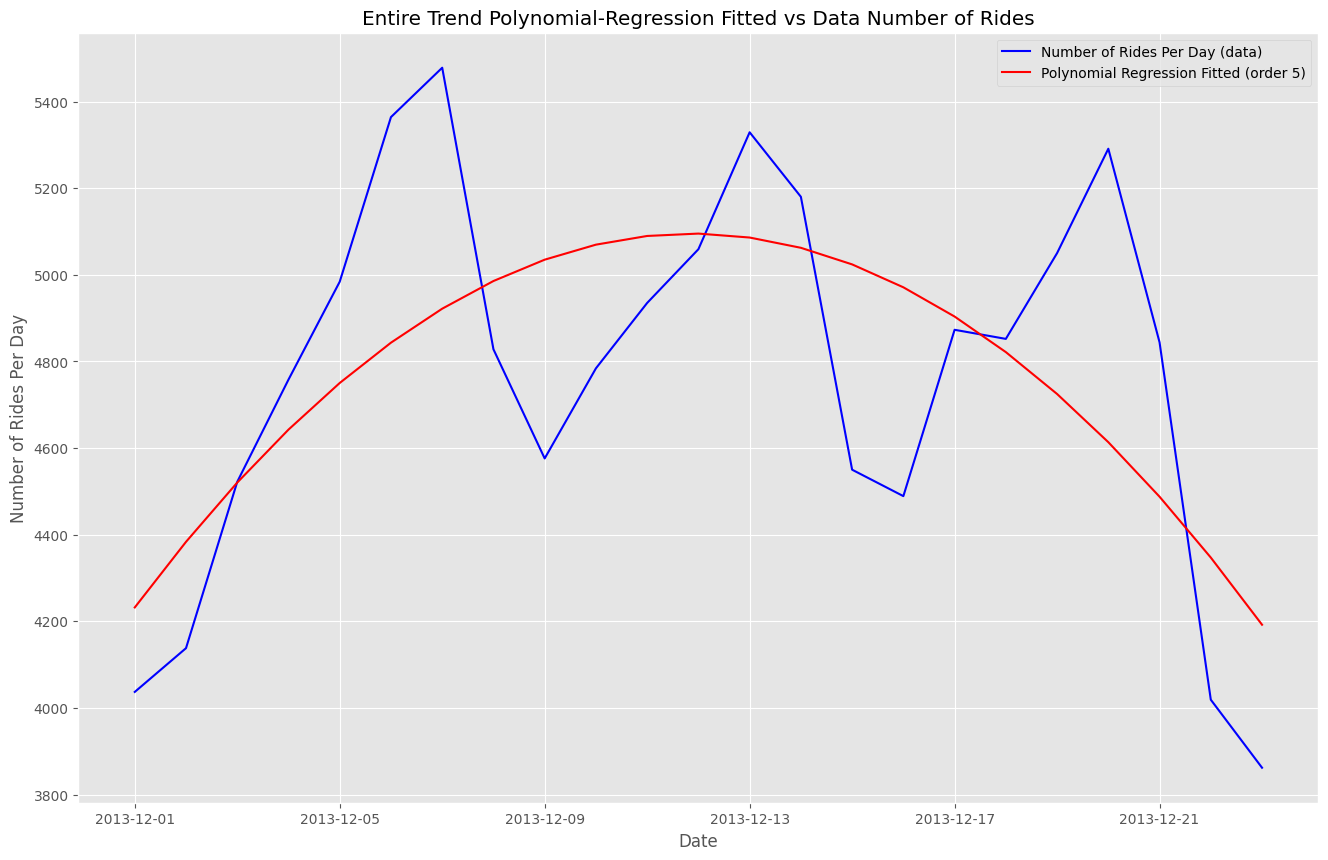

In [82]:
# Ensure 'series3' has a DatetimeIndex
if not isinstance(series3.index, pd.DatetimeIndex):
    series3['day'] = pd.to_datetime(series3['day']) # Changed series1 to series3
    series3.set_index('day', inplace=True)

# Convert the index to numeric (day of the year) for polynomial fitting
numeric_index = series3.index.map(pd.Timestamp.to_julian_date)

# Perform polynomial fitting
coefs = poly.polyfit(numeric_index, series3['count'], 5)
ffit = poly.polyval(numeric_index, coefs)

# Plot the results
plt.plot(series3.index, series3['count'], color='blue', label='Number of Rides Per Day (data)')
plt.plot(series3.index, ffit, color='red', label='Polynomial Regression Fitted (order 5)')
plt.xlabel('Date')
plt.ylabel('Number of Rides Per Day')
plt.title('Entire Trend Polynomial-Regression Fitted vs Data Number of Rides')
plt.legend()
plt.show()

In [83]:
df3['dayofweek'] = df3['pickup_datetime'].dt.dayofweek

In [84]:
print('Tootal weeks in the duration of the time series : %i' %(len(series)/7))

Tootal weeks in the duration of the time series : 3


In [85]:
count2 =  df3.groupby('dayofweek').count()['id']
series2 = pd.DataFrame(({'day': count2.index, 'count': count2.values / 26}))
series2.head()

,day,count
0,0,309.730769
1,1,646.615385
2,2,190.423077
3,3,248.500000
4,4,289.923077


In [86]:
x_new1 =  series2.index.copy()

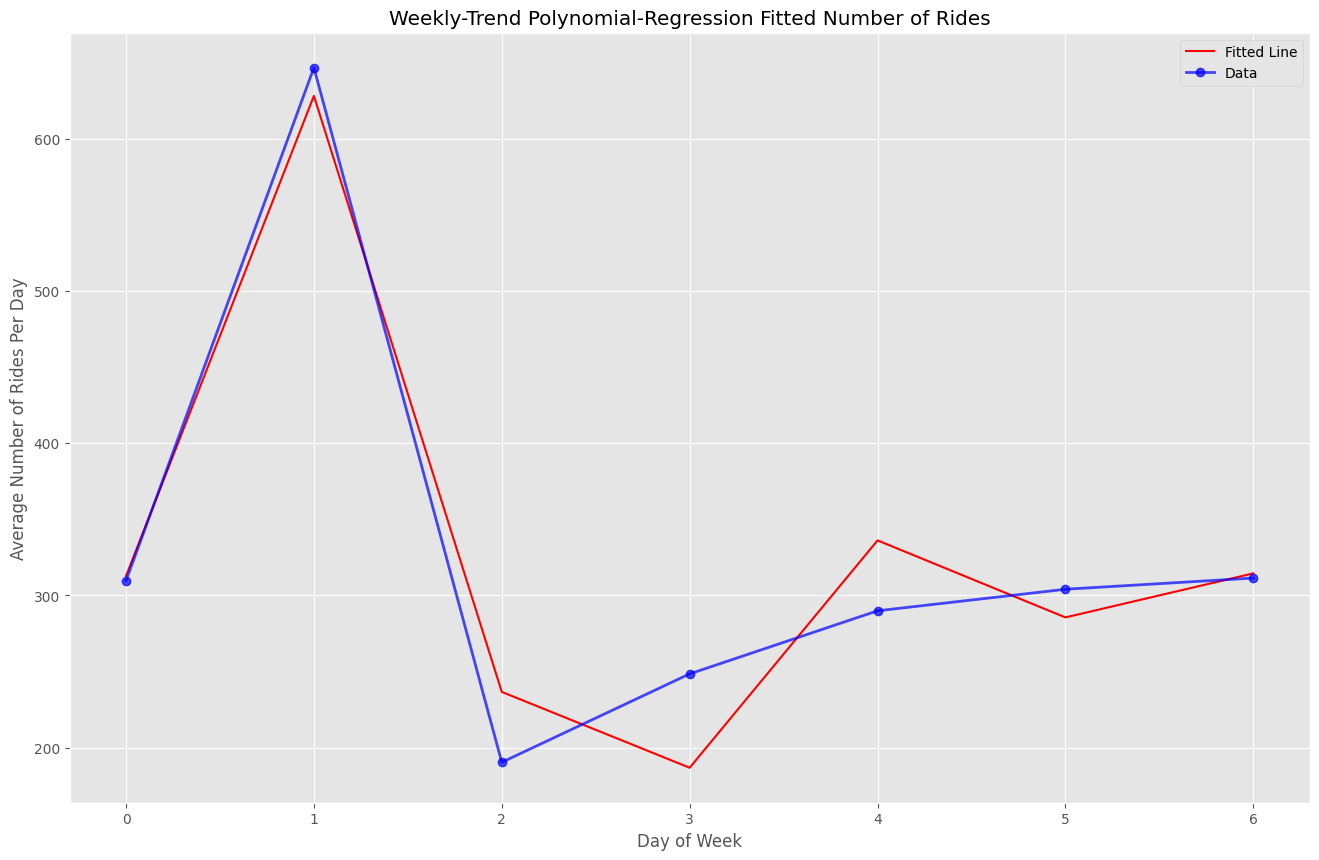

In [87]:
# Perform polynomial fitting
coefs = poly.polyfit(series2.index, series2['count'], 5)
ffit = poly.polyval(x_new1, coefs)

# Plot the fitted line and the original data
plt.plot(x_new1, ffit, color='red', label='Fitted Line')
plt.plot(series2['day'], series2['count'], 'bo-', lw=2, alpha=0.7, label='Data')
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression Fitted Number of Rides')
plt.show()

In [88]:
deseason = pd.DataFrame(({'dayofweek': x_new1 , 'fitted_count': ffit}))
deseason.head(7)

,dayofweek,fitted_count
0,0,312.812812
1,1,628.123127
2,2,236.653721
3,3,186.859141
4,4,336.153721
5,5,285.584665
6,6,314.505120


In [89]:
count1 =  df3.groupby('date').count()['id']
final = pd.DataFrame(({'day': count1.index, 'count': count1.values}))

In [90]:
final['dayofweek'] = final['day'].dt.dayofweek

In [91]:
final.head(10)

,day,count,dayofweek
0,2013-12-24,7558,1
1,2013-12-25,4951,2
2,2013-12-26,6461,3
3,2013-12-27,7538,4
4,2013-12-28,7906,5
5,2013-12-29,8097,6
6,2013-12-30,8053,0
7,2013-12-31,9254,1


In [92]:
final_df3 = pd.merge(final,
                    deseason[['dayofweek', 'fitted_count']],
                    left_on = 'dayofweek',
                    right_on = 'dayofweek',
                    how = 'left')


In [93]:
final_df3['final_count'] = (round(final_df3['count'] - final_df3['fitted_count']))

In [94]:
final_df3.head(10)

,day,count,dayofweek,fitted_count,final_count
0,2013-12-24,7558,1,628.123127,6930.0
1,2013-12-25,4951,2,236.653721,4714.0
2,2013-12-26,6461,3,186.859141,6274.0
3,2013-12-27,7538,4,336.153721,7202.0
4,2013-12-28,7906,5,285.584665,7620.0
5,2013-12-29,8097,6,314.505120,7782.0
6,2013-12-30,8053,0,312.812812,7740.0
7,2013-12-31,9254,1,628.123127,8626.0


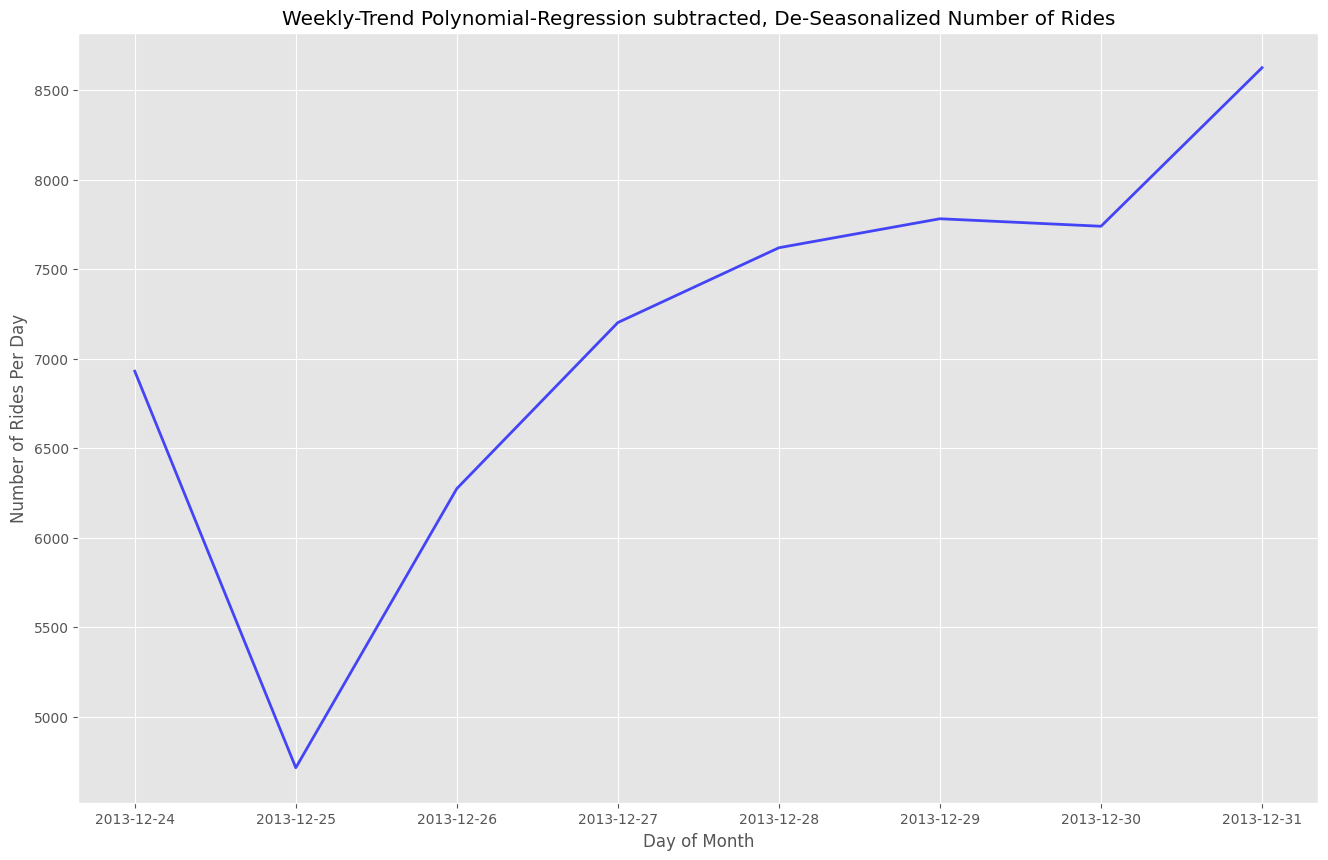

In [95]:
plt.plot(final_df3.day, final_df3.final_count , 'b-', lw=2, alpha=0.7)
plt.xlabel('Day of Month')
plt.ylabel('Number of Rides Per Day')
plt.title('Weekly-Trend Polynomial-Regression subtracted, De-Seasonalized Number of Rides')
plt.show()

In [96]:
# Remove the data around January 21st to clean the dataset
start_date = '2013-12-29'
end_date = '2013-12-31'
final_df3_cleaned = final_df3[(final_df2['day'] < start_date) | (final_df2['day'] > end_date)]

In [97]:
final_df3_cleaned.columns

Index(['day', 'count', 'dayofweek', 'fitted_count', 'final_count'], dtype='object')

In [98]:
df3 = final_df3_cleaned[['day', 'final_count']]

In [99]:
df3.set_index('day', inplace = True)
df3.index = pd.RangeIndex(len(df3.index))
df3.head()

,final_count
0,6930.0
1,4714.0
2,6274.0
3,7202.0
4,7620.0


In [100]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(df3['final_count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

,Value,Label
0,-2.700746,Test Statistic
1,0.235773,p-value
2,1.000000,#Lags Used
3,6.000000,Number of Observations Used
4,-6.878375,Critical value for 1%
5,-4.603288,Critical value for 5%
6,-3.770622,Critical value for 10%


In [101]:
# Define the tsplot function
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [102]:
num_lags = min(10, len(df3) // 2 - 1)  # Try with a smaller number of lags

(<Axes: title={'center': 'De-Trended Time Series'}>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: title={'center': 'Partial Autocorrelation'}>)

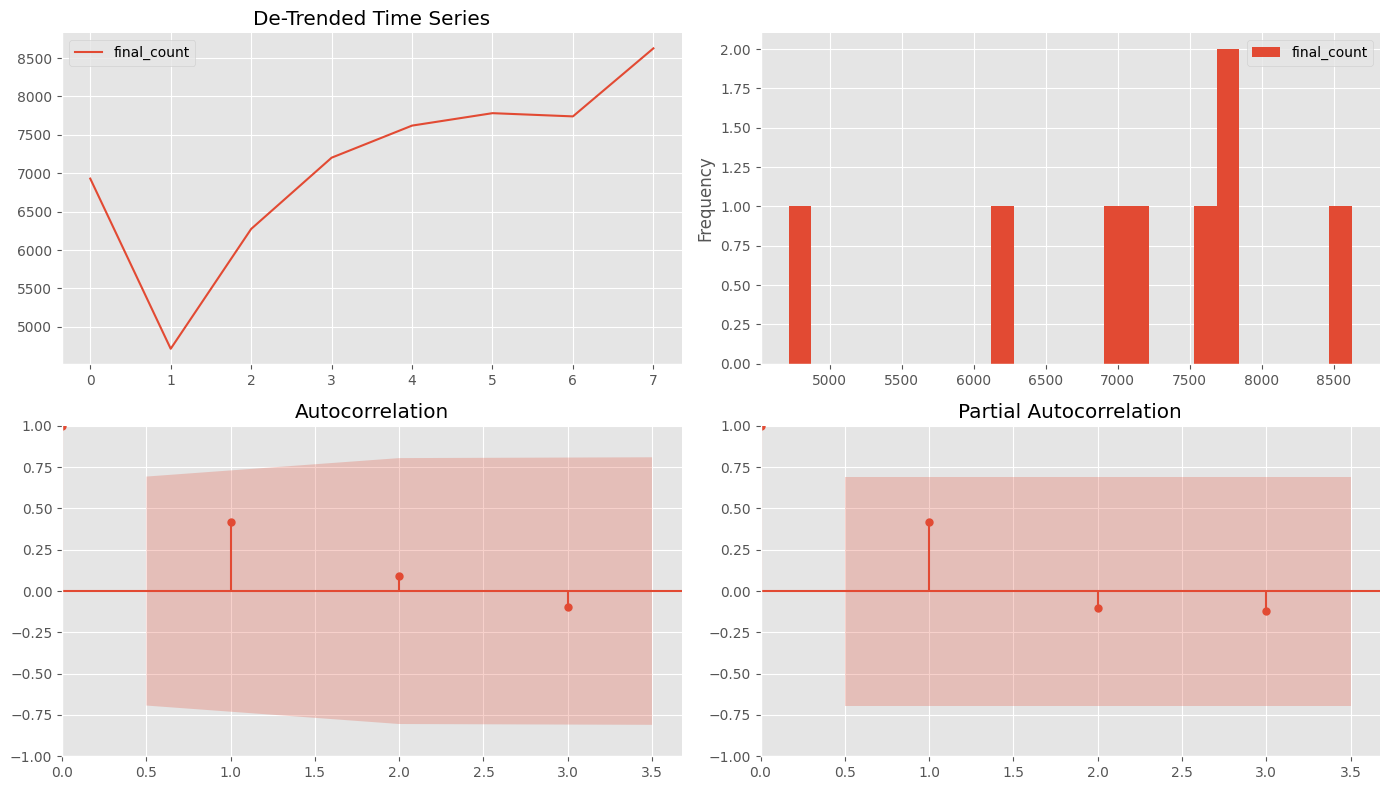

In [103]:
tsplot(df3, title='De-Trended Time Series', lags=num_lags)

In [104]:
n_sample = df3.shape[0]
print('New length of the entire dataset is : %i' %n_sample)

New length of the entire dataset is : 8


In [105]:
n_train=int(0.90*n_sample) + 1
n_forecast=n_sample-n_train

ts_train = df2.iloc[:n_train]['final_count']
ts_test = df2.iloc[n_train:]['final_count']

In [106]:
print(('Number of in sample training dataset : %i' %len(ts_train)))
print(('Number of out of sample testing dataset : %i' %len(ts_test)))

Number of in sample training dataset : 8
Number of out of sample testing dataset : 10


In [107]:
arima101 = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,1), seasonal_order= (1,0,1,7), simple_differencing=True)
model_results = arima101.fit()
model_results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       final_count   No. Observations:                    8
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                 -59.912
Date:                           Tue, 24 Sep 2024   AIC                            129.824
Time:                                   18:22:09   BIC                            130.222
Sample:                                        0   HQIC                           127.145
                                             - 8                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9543      0.150      6.370      0.000       0.661       1.248
ma.L1          0.9977     33.449      0.030      0.976     -64.562      66.557
ar.S.L7        0.9980      2.726      0.366      0.714      -4.345       6.341
ma.S.L7       -0.9297     46.234     -0.020      0.984     -91.546      89.686
sigma2       3.94e+04      0.001   3.94e+07      0.000    3.94e+04    3.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.62
Prob(Q):                              0.89   Prob(JB):                         0.16
Heteroskedasticity (H):               1.62   Skew:                            -1.51
Prob(H) (two-sided):                  0.70   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.72e+26. Standard errors may be unstable.
"""

In [108]:
#credit to Jeffery Yau @ https://www.youtube.com/watch?v=tJ-O3hk1vRwhttps://www.youtube.com/watch?v=tJ-O3hk1vRw
#PyData SF2016 conference

import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue

    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

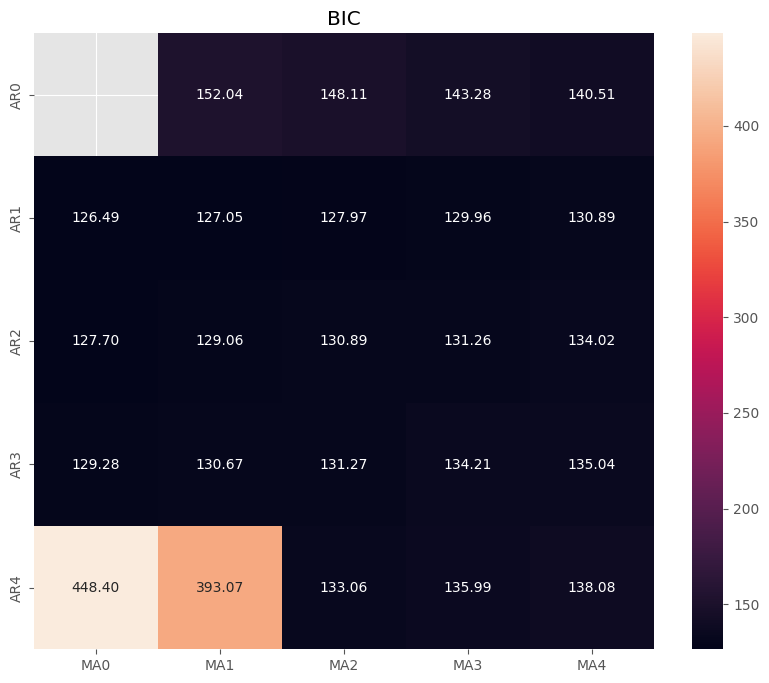

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');